In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import ttest_ind, t
import matplotlib.dates as mdates

# Importing Datasets

In [2]:
data = pd.read_csv("QVI_data.csv")
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NCC,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smith,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smith,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246734,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,YOUNG SINGLES/COUPLES,Premium
246735,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium
246736,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Dorito,YOUNG SINGLES/COUPLES,Premium
246737,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Dorito,YOUNG SINGLES/COUPLES,Premium


# Data Wrangling

The client has selected store numbers 77, 86 and 88 as trial stores with a trial period of Feb 2019 to April 2019. The client also wants control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:

Monthly overall sales revenue,
Monthly number of customers,
Monthly number of transactions per customer.
To choose the control stores, we will create the metrics of interest and filter to stores that are present throughout the pre-trial period.

First, we want to add a column with the year/month of the transaction.

In [3]:
# Convert 'DATE' to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])
# Add a column for year/month 
data['YEARMONTH'] = data['DATE'].dt.strftime('%Y%m').astype('str')
data


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NCC,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smith,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smith,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,201808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246734,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,YOUNG SINGLES/COUPLES,Premium,201903
246735,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium,201808
246736,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Dorito,YOUNG SINGLES/COUPLES,Premium,201811
246737,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Dorito,YOUNG SINGLES/COUPLES,Premium,201812


## Measures of Interests 

For each store and month, calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [4]:
measure_overtime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    NUM_OF_TRANSACTIONS=pd.NamedAgg(column='STORE_NBR', aggfunc='count'), 
    TOTAL_SALES=pd.NamedAgg(column='TOT_SALES', aggfunc='sum'), 
    NUM_OF_CUSTOMERS=pd.NamedAgg(column='LYLTY_CARD_NBR', aggfunc='nunique'),
    TOTAL_QTY=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')).reset_index()

# Calculate additional metrics
measure_overtime['TRANSACTIONS_PER_CUSTOMER'] = (measure_overtime['NUM_OF_TRANSACTIONS'] / measure_overtime['NUM_OF_CUSTOMERS']).round(2)
measure_overtime['CHIPS_PER_CUSTOMER'] = (measure_overtime['TOTAL_QTY'] / measure_overtime['NUM_OF_CUSTOMERS']).round(2)
measure_overtime['AVG_PRICE_PER_UNIT'] = (measure_overtime['TOTAL_SALES'] / measure_overtime['TOTAL_QTY']).round(2)

# Drop unnecessary columns
measure_overtime.drop(['NUM_OF_TRANSACTIONS','TOTAL_QTY'], axis=1, inplace=True)


measure_overtime = pd.DataFrame(measure_overtime)
measure_overtime

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
0,1,201807,188.9,47,1.04,1.23,3.26
1,1,201808,168.4,41,1.00,1.27,3.24
2,1,201809,268.1,57,1.04,1.25,3.78
3,1,201810,175.4,39,1.03,1.31,3.44
4,1,201811,184.8,44,1.02,1.25,3.36
...,...,...,...,...,...,...,...
3160,272,201902,385.3,44,1.07,2.02,4.33
3161,272,201903,421.9,48,1.06,2.02,4.35
3162,272,201904,445.1,54,1.04,1.94,4.24
3163,272,201905,314.6,34,1.18,2.09,4.43


In [65]:
# Group by 'STORE_NBR' and filter stores with exactly 12 entries (months)
stores_with_full_obs = measure_overtime.groupby('STORE_NBR').filter(lambda x: len(x) == 12)

# Get the unique store numbers that have full observation periods
stores_with_full_obs = stores_with_full_obs['STORE_NBR'].unique()

# Filter to the pre-trial period (before February 2019)
pre_trial_measures = measure_overtime[(measure_overtime['YEARMONTH'] < '201902') & 
                                     (measure_overtime['STORE_NBR'].isin(stores_with_full_obs))]

pre_trial_measures = pd.DataFrame(pre_trial_measures)
pre_trial_measures


,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
0,1,201807,188.9,47,1.04,1.23,3.26
1,1,201808,168.4,41,1.00,1.27,3.24
2,1,201809,268.1,57,1.04,1.25,3.78
3,1,201810,175.4,39,1.03,1.31,3.44
4,1,201811,184.8,44,1.02,1.25,3.36
...,...,...,...,...,...,...,...
3155,272,201809,294.5,31,1.13,2.23,4.27
3156,272,201810,405.1,41,1.17,2.29,4.31
3157,272,201811,355.8,39,1.10,2.13,4.29
3158,272,201812,363.1,43,1.00,1.88,4.48


In [66]:
pre_trial_measures.describe()

,STORE_NBR,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
count,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000
mean,136.737452,586.001462,67.583012,1.140634,2.084539,3.814159
std,78.561140,363.068511,34.563206,0.107406,0.445936,0.459138
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.930000
25%,68.000000,260.500000,39.000000,1.040000,1.810000,3.470000
50%,137.000000,654.500000,78.000000,1.130000,2.180000,3.620000
75%,204.000000,879.000000,98.000000,1.230000,2.440000,4.330000
max,272.000000,1557.600000,144.000000,1.500000,2.890000,5.400000


In [61]:
during_trial_measures = measure_overtime[(measure_overtime['YEARMONTH'] >= '201902') & (measure_overtime['YEARMONTH'] <= '201904') & 
                                     (measure_overtime['STORE_NBR'].isin(stores_with_full_obs))]
during_trial_measures.describe()

,STORE_NBR,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,136.737452,573.225740,65.894466,1.134839,2.086795,3.817040
std,78.590060,357.558914,33.867072,0.106585,0.452296,0.455088
min,1.000000,3.000000,1.000000,1.000000,1.000000,2.280000
25%,68.000000,242.100000,38.000000,1.040000,1.810000,3.480000
50%,137.000000,639.400000,74.000000,1.130000,2.200000,3.630000
75%,204.000000,866.400000,96.000000,1.230000,2.440000,4.330000
max,272.000000,1467.000000,133.000000,1.470000,2.930000,4.700000


In Pre-Trial period, the average sales per store per month is $586, along with an average of 1.14 transactions per customer and $3.81 per chip unit. During the trial period (from February to April, 2019), the average sales per store per month is $573, indicating substential impact on the stores' transaction values. Even though with just 3 months of trial, multiple Key Performance Indicators, such as number of customers, transaction per customer, chips per customer and average price per unit remains relatively close to the 7 months of data pre-trial.  

### Correlation & Magnitude Distance Calculation

In [6]:
def calculate_corr(input_table, metric_col, trial_store):
   trial_data = input_table[input_table['STORE_NBR'] == trial_store]

   results = []
    
    # Loop through all stores in the dataset (excluding the trial store)
   for control_store in input_table['STORE_NBR'].unique():
        if control_store != trial_store:
            # Filter control store data
            control_data = input_table[input_table['STORE_NBR'] == control_store]
            
            # Merge trial and control store data on YEARMONTH
            merged_data = pd.merge(trial_data, control_data, on="YEARMONTH", suffixes=('_TRIAL', '_CONTROL'))
            
            # Calculate the correlation for the selected metric
            correlation = merged_data[[f'{metric_col}_TRIAL', f'{metric_col}_CONTROL']].corr().iloc[0, 1]
            
            # Append the result (trial store, control store, and correlation) to the results list
            results.append([trial_store, control_store, correlation])
    
   correlation_df = pd.DataFrame(results, columns=['STORE_NBR_TRIAL', 'STORE_NBR_CONTROL', 'CORRELATION'])
    
   return correlation_df



In [7]:
def calculate_magnitude_distance(input_table, metric_col, trial_store):
    # Filter trial store data
    trial_data = input_table[input_table['STORE_NBR'] == trial_store]
   
    distance_vals = []
    
    # Loop through all stores in the dataset (excluding the trial store)
    for control_store in input_table['STORE_NBR'].unique():
        if control_store != trial_store:
            # Filter control store data
            control_data = input_table[input_table['STORE_NBR'] == control_store]
            
            # Merge the trial and control store data on YEARMONTH
            merged_data = pd.merge(trial_data, control_data, on='YEARMONTH', suffixes=('_TRIAL', '_CONTROL'))
            
            # Calculate the absolute difference (magnitude distance)
            magnitude_distance = abs(merged_data[f'{metric_col}_TRIAL'] - merged_data[f'{metric_col}_CONTROL'])
            
            # Append the result (trial store, control store, YEARMONTH, and magnitude distance)
            for year_month, dist in zip(merged_data['YEARMONTH'], magnitude_distance):
                distance_vals.append([trial_store, control_store, year_month, dist])

    # Create a DataFrame for magnitude distances
    distance_df = pd.DataFrame(distance_vals, columns=['STORE_NBR_TRIAL', 'STORE_NBR_CONTROL', 'YEARMONTH', 'MAGNITUDE_DISTANCE'])

    # Standardize the magnitude distance (min-max normalization)
    min_max_dist = distance_df.groupby(['STORE_NBR_TRIAL', 'YEARMONTH'])['MAGNITUDE_DISTANCE'].agg(['min', 'max']).reset_index()
    distance_df = pd.merge(distance_df, min_max_dist, on=['STORE_NBR_TRIAL', 'YEARMONTH'])

    # Apply min-max normalization
    distance_df['magnitudeMeasure'] = 1 - (distance_df['MAGNITUDE_DISTANCE'] - distance_df['min']) / (distance_df['max'] - distance_df['min'])

    # Calculate the mean of the standardized magnitude measure by trial and control stores
    final_dist_df = distance_df.groupby(['STORE_NBR_TRIAL', 'STORE_NBR_CONTROL'])['magnitudeMeasure'].mean().reset_index()
    final_dist_df.rename(columns={'magnitudeMeasure': 'MAGNITUDE'}, inplace=True)

    return final_dist_df

### Helper Functions

In [8]:
def calculate_scores_for_trial(data, trial_store, metric):

    correlation = calculate_corr(data, metric, trial_store)
    magnitude = calculate_magnitude_distance(data, metric, trial_store)
    
    correlation.sort_values(by='CORRELATION', ascending=False, inplace=True)
    magnitude.sort_values(by='MAGNITUDE', ascending=False, inplace=True)
    
    # Combine correlation and magnitude for score calculation
    score = pd.concat([correlation, magnitude['MAGNITUDE']], axis=1)
    
    # Dynamically name the weighted score based on the metric
    weighted_score_column_name = f'WEIGHTED_SCORE_{metric.upper().split('_')[-1]}'
    
    score[weighted_score_column_name] = 0.5 * score['CORRELATION'] + 0.5 * score['MAGNITUDE']
    
    return score

In [9]:
def match_and_calculate_final_score(trial_store, score_sales, score_customers):

    weighted_score_sales_name = "WEIGHTED_SCORE_SALES"
    weighted_score_customers_name = "WEIGHTED_SCORE_CUSTOMERS"
    # Ensure the correct column names are being accessed
    score_sales.set_index(['STORE_NBR_TRIAL', 'STORE_NBR_CONTROL'], inplace=True)
    score_customers.set_index(['STORE_NBR_TRIAL', 'STORE_NBR_CONTROL'], inplace=True)
    
    # Concatenate the weighted scores from sales and customers
    score_control = pd.concat([score_sales[weighted_score_sales_name], score_customers[weighted_score_customers_name]], axis=1)
    
    # Calculate the final control store score
    score_control['FINAL_CONTROL_SCORE'] = score_control[weighted_score_sales_name] * 0.5 + score_control[weighted_score_customers_name] * 0.5
    
    return score_control

In [10]:
def assign_store_types(measure_overtime_sales, trial_store, control_store):

    measure_overtime_sales['STORE_TYPE'] = measure_overtime_sales['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x in control_store else 'Other stores'))
    return measure_overtime_sales

In [11]:
def plot_metric_by_month(past_data, metric):

    y_label = 'Total Sales' if metric == 'TOTAL_SALES' else 'Total Customers'
    title = f"{y_label} by Month"
    
    # Plotting the data
    plt.figure(figsize=(14, 6), dpi=200)
    plt.title(title)
    plt.xlabel("Month of Operation")
    plt.ylabel(y_label)
    

    ax = sns.barplot(x='TRANSACTION_MONTH', y=metric, hue='STORE_TYPE', data=past_data, palette='plasma')
    
    plt.show()

In [12]:
def apply_scaling_factor(data, trial_value, control_value, control_column, metric_column, control_store):

    # Calculate the scaling factor
    scaling_factor = trial_value / control_value
    
    scaled_data = data[data['STORE_NBR'].isin(control_store)].copy()
    
    # Apply the scaling factor to the control column
    scaled_data[control_column] = (scaled_data[metric_column] * scaling_factor).round(1)
    
    return scaled_data


In [13]:
def calculate_percentage_difference(scaled_control_data, trial_store, metric, measure_overtime_data):

    # Define the column names for control and trial data dynamically based on the metric
    control_column_name = f'CONTROL_{metric.upper().split("_")[-1]}_SUM'
    trial_column_name = f'TRIAL_{metric.upper().split("_")[-1]}'
    
    # Extract the trial store's data 
    trial_data = measure_overtime_data[measure_overtime_data['STORE_NBR'] == trial_store][['YEARMONTH', metric]]
    
    # Merge the scaled control data with the trial data 
    percentage_difference = pd.merge(scaled_control_data[['YEARMONTH', control_column_name]], trial_data, on='YEARMONTH', how='left')

    percentage_difference.rename(columns={metric: trial_column_name}, inplace=True)
    
    # Calculate percentage difference
    percentage_difference['PERCENTAGE_DIFFERENCE'] = abs(percentage_difference[control_column_name] - percentage_difference[trial_column_name]) / percentage_difference[control_column_name]
    
    return percentage_difference


In [14]:
def perform_hypothesis_test(percentage_difference, alpha=0.05):

    # Calculate STD in pre-trial period
    std_dev = percentage_difference[percentage_difference['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
    df = 7
    t_critical = stats.t.ppf(0.95, df)
    print('H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0')
    print(f"Degree of Freedom: {df} | alpha = 0.05 | std_dev = {std_dev}")
    print(f"T-Critical Value: {t_critical}")

    percentage_difference['tValue'] = (percentage_difference['PERCENTAGE_DIFFERENCE'] - 0) / std_dev

    percentage_diff_trial_period = percentage_difference[(percentage_difference['YEARMONTH'] >= '201902') & (percentage_difference['YEARMONTH'] <= '201904')]

    for (index, row) in percentage_diff_trial_period.iterrows():
        if row.tValue > t_critical:
            print(f"{row.YEARMONTH}: Reject H0. There is sufficient evidence to conclude that sales/customers differ.")
        else:
            print(f"{row.YEARMONTH}: Fail to Reject H0.")
    print(percentage_diff_trial_period)

In [15]:
def create_trial_assessment(measure_overtime_data, std_dev, metric='TOTAL_SALES'):

    # Filter and prepare data for trial and control stores
    past_data = measure_overtime_data[measure_overtime_data['STORE_TYPE'].isin(['Trial', 'Control'])]
    
    past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')
    
    # Create trial assessment for all stores (Trial + Control)
    trial_assessment = past_data[['STORE_TYPE', 'TRANSACTION_MONTH', 'YEARMONTH', metric]]
    
    # Calculate Control store 95th percentile (metric * (1 + std_dev * 2))
    past_controls_95 = trial_assessment[trial_assessment['STORE_TYPE'] == 'Control'].copy()
    past_controls_95[metric] = past_controls_95[metric] * (1 + std_dev * 2)
    past_controls_95['STORE_TYPE'] = f'Control 95th % confidence interval'  
    
    # Calculate Control store 5th percentile (metric * (1 - std_dev * 2))
    past_controls_5 = trial_assessment[trial_assessment['STORE_TYPE'] == 'Control'].copy()
    past_controls_5[metric] = past_controls_5[metric] * (1 - std_dev * 2)
    past_controls_5['STORE_TYPE'] = f'Control 5th % confidence interval'  
    
    # Combine the data
    trial_assessment = pd.concat([trial_assessment, past_controls_95, past_controls_5], ignore_index=True)
    
    trial_assessment.set_index('TRANSACTION_MONTH', inplace=True)
    
    return trial_assessment


In [16]:
def plot_data(trial_assessment, metric, highlight_period_start='201902', highlight_period_end='201904', 
              y_label=None, title=None, ylim=None):
    plt.figure(figsize=(12, 7))

    # Plot the data with a lineplot
    sns.lineplot(data=trial_assessment, x='TRANSACTION_MONTH', y=metric, hue='STORE_TYPE', palette='plasma', linewidth=3)

    # Highlight the trial period range using axvspan
    plt.axvspan(pd.to_datetime(f'{highlight_period_start[:4]}-{highlight_period_start[4:]}-01'), 
                pd.to_datetime(f'{highlight_period_end[:4]}-{highlight_period_end[4:]}-30'), 
                color='orange', alpha=0.3, label=f'Trial Period ({highlight_period_start} to {highlight_period_end})')

    # Labeling
    plt.xlabel('MONTH OF OPERATION', fontsize=14)
    plt.ylabel(y_label if y_label else metric.replace('_', ' ').title(), fontsize=14)
    plt.title(title if title else f'{metric.replace("_", " ").title()} BY MONTH', fontsize=15)

    # Set the x-axis to display months properly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, fontsize=12)

    # If ylim is not passed, calculate dynamic limits based on the metric
    if ylim is None:
        min_value = trial_assessment[metric].min()
        max_value = trial_assessment[metric].max()
        margin = (max_value - min_value) * 0.8 
        plt.ylim(0, max_value + margin)  # Increase margin
    else:
        plt.ylim(ylim)  # Use provided ylim range

    # Add a legend and grid
    plt.legend(title='Store Type', loc='upper left')
    plt.grid(True)

    # Tighten layout and show plot
    plt.tight_layout()
    plt.show()


### Trial Store 77

In [17]:
trial_store = 77

In [18]:
# Calculate scores for each metric (Sales and Customers)
score_sales = calculate_scores_for_trial(pre_trial_measures, trial_store, 'TOTAL_SALES')
score_customers = calculate_scores_for_trial(pre_trial_measures, trial_store, 'NUM_OF_CUSTOMERS')
            
# Calculate final control store score
score_control = match_and_calculate_final_score(trial_store, score_sales, score_customers)
score_control

# Get the best matching control store based on the final score
control_store_row = score_control.loc[score_control.groupby('STORE_NBR_TRIAL')['FINAL_CONTROL_SCORE'].idxmax()]
control_store_row

,,WEIGHTED_SCORE_SALES,WEIGHTED_SCORE_CUSTOMERS,FINAL_CONTROL_SCORE
STORE_NBR_TRIAL,STORE_NBR_CONTROL,,,
77,233,0.980368,0.978323,0.979345


#### For Trial Store 77, the best matched Control Store is 233

#### Sales Data Analysis

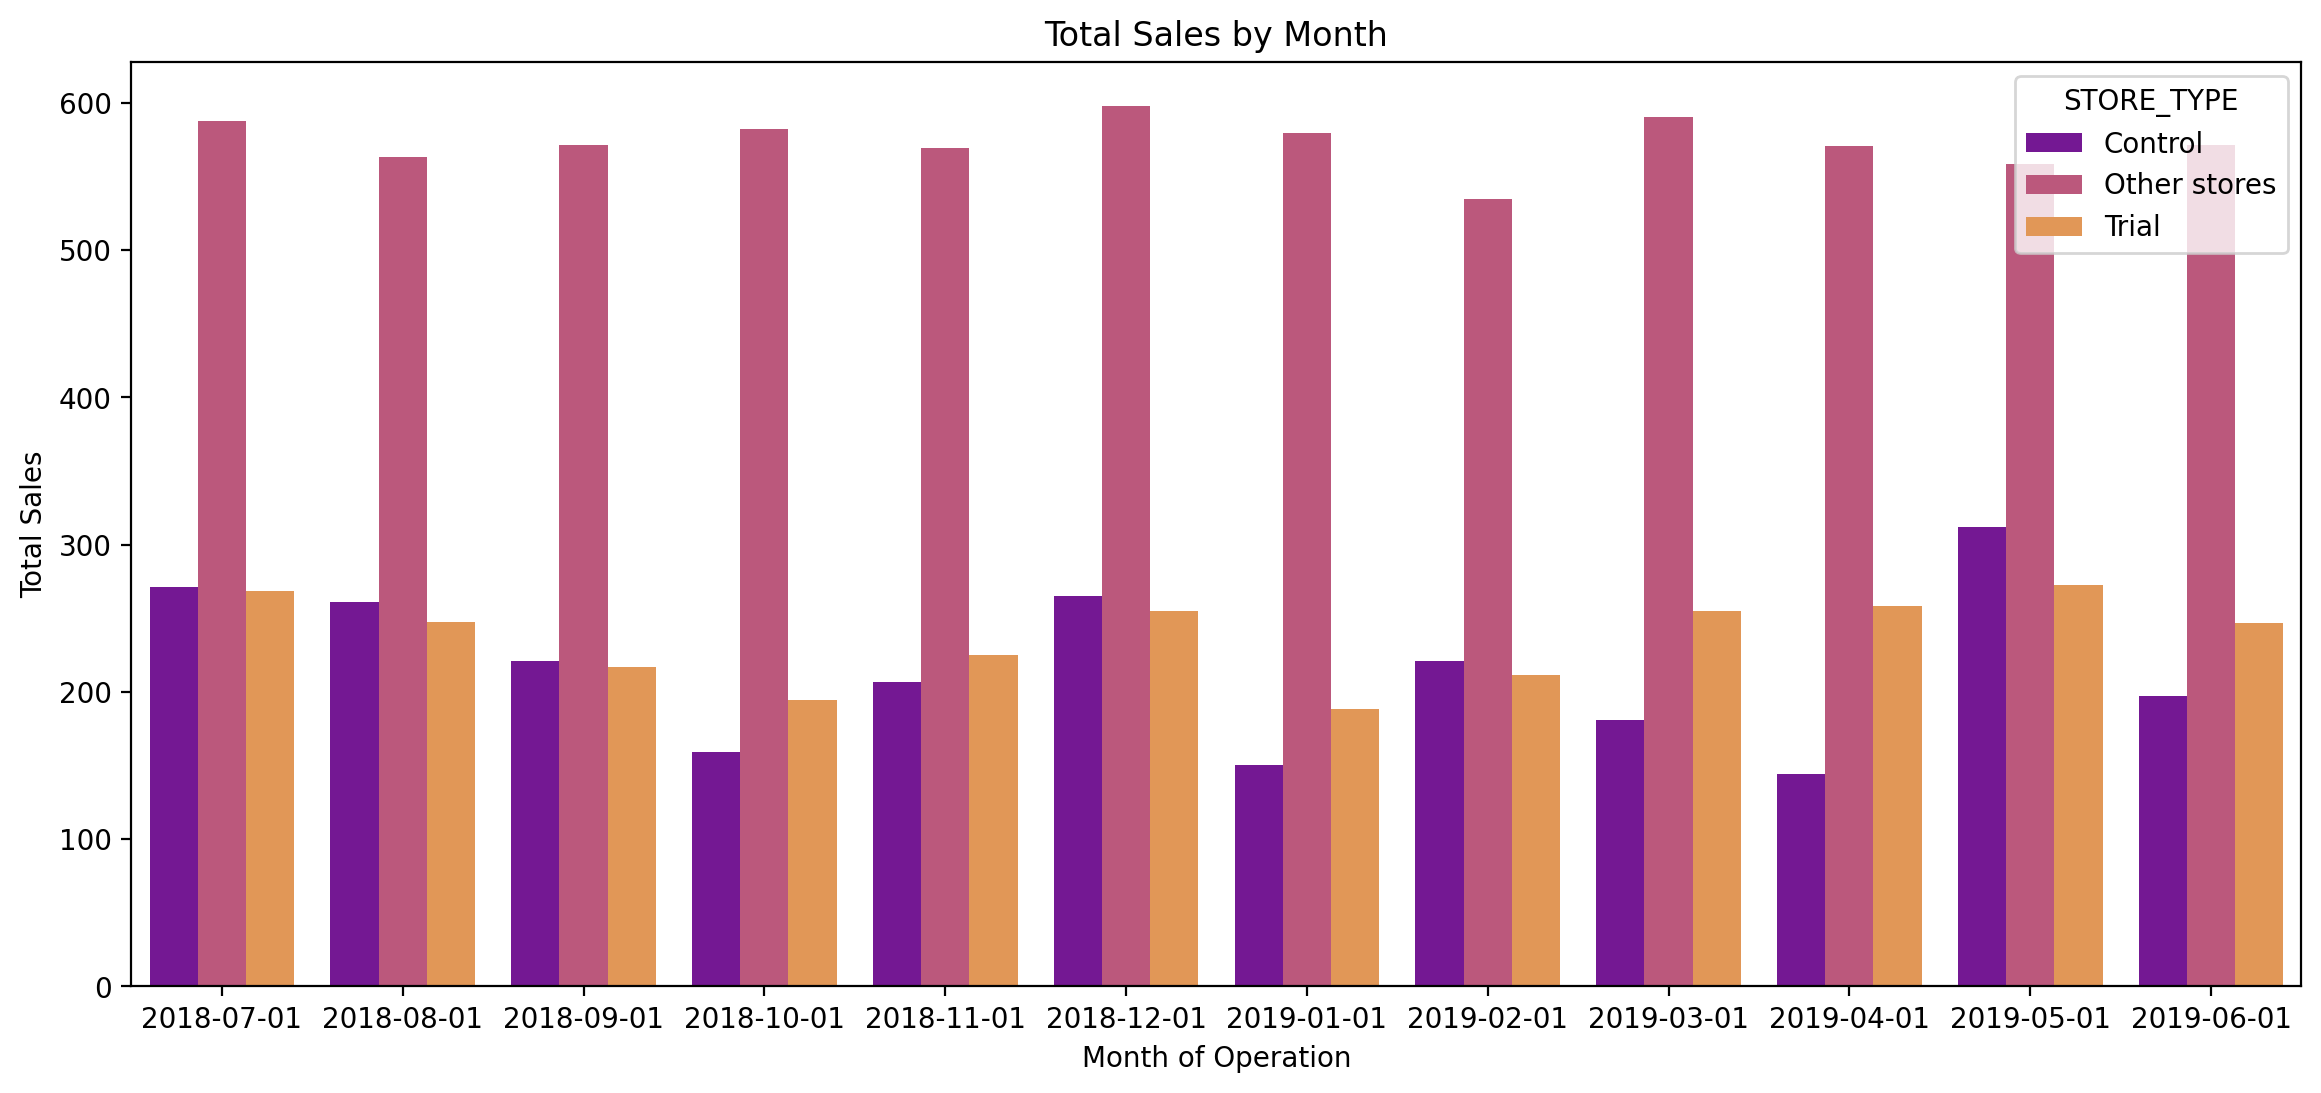

In [19]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_sales = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_sales = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['TOTAL_SALES'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_sales['TRANSACTION_MONTH'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_sales, 'TOTAL_SALES')

In [20]:
# Apply scaling factors for sales
trial_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
control_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
scaled_control_sales = apply_scaling_factor(measure_overtime_sales, trial_sales, control_sales, 'CONTROL_SALES_SUM', 'TOTAL_SALES', control_store)
scaled_control_sales

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,STORE_TYPE,CONTROL_SALES_SUM
2695,233,201807,271.2,47,1.04,1.68,3.43,Control,282.0
2696,233,201808,260.7,44,1.02,1.64,3.62,Control,271.1
2697,233,201809,220.9,40,1.08,1.70,3.25,Control,229.7
2698,233,201810,159.3,32,1.00,1.50,3.32,Control,165.6
2699,233,201811,206.5,39,1.03,1.56,3.39,Control,214.7
2700,233,201812,265.4,43,1.05,1.63,3.79,Control,276.0
2701,233,201901,150.5,31,1.00,1.32,3.67,Control,156.5
2702,233,201902,220.7,42,1.02,1.52,3.45,Control,229.5
2703,233,201903,180.6,35,1.03,1.49,3.47,Control,187.8
2704,233,201904,144.2,27,1.07,1.52,3.52,Control,149.9


In [21]:
# Calculate percentage difference 
percentage_difference_sales = calculate_percentage_difference(scaled_control_sales, trial_store, 'TOTAL_SALES', measure_overtime_sales)
percentage_difference_sales

,YEARMONTH,CONTROL_SALES_SUM,TRIAL_SALES,PERCENTAGE_DIFFERENCE
0,201807,282.0,268.4,0.048227
1,201808,271.1,247.5,0.087053
2,201809,229.7,216.8,0.056160
3,201810,165.6,194.3,0.173309
4,201811,214.7,224.9,0.047508
5,201812,276.0,255.2,0.075362
6,201901,156.5,188.4,0.203834
7,201902,229.5,211.6,0.077996
8,201903,187.8,255.1,0.358360
9,201904,149.9,258.1,0.721815


#### Hypothesis Testing

In [22]:
perform_hypothesis_test(percentage_difference_sales)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.0636103887674503
T-Critical Value: 1.894578605061305
201902: Fail to Reject H0.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
  YEARMONTH  CONTROL_SALES_SUM  TRIAL_SALES  PERCENTAGE_DIFFERENCE     tValue
7    201902              229.5        211.6               0.077996   1.226146
8    201903              187.8        255.1               0.358360   5.633670
9    201904              149.9        258.1               0.721815  11.347432


#### Trial Assessment

In [23]:
std_dev = percentage_difference_sales[percentage_difference_sales['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_sales, std_dev, metric='TOTAL_SALES')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,TOTAL_SALES
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,268.400000
2018-08-01,Trial,201808,247.500000
2018-09-01,Trial,201809,216.800000
2018-10-01,Trial,201810,194.300000
2018-11-01,Trial,201811,224.900000
2018-12-01,Trial,201812,255.200000
2019-01-01,Trial,201901,188.400000
2019-02-01,Trial,201902,211.600000
2019-03-01,Trial,201903,255.100000


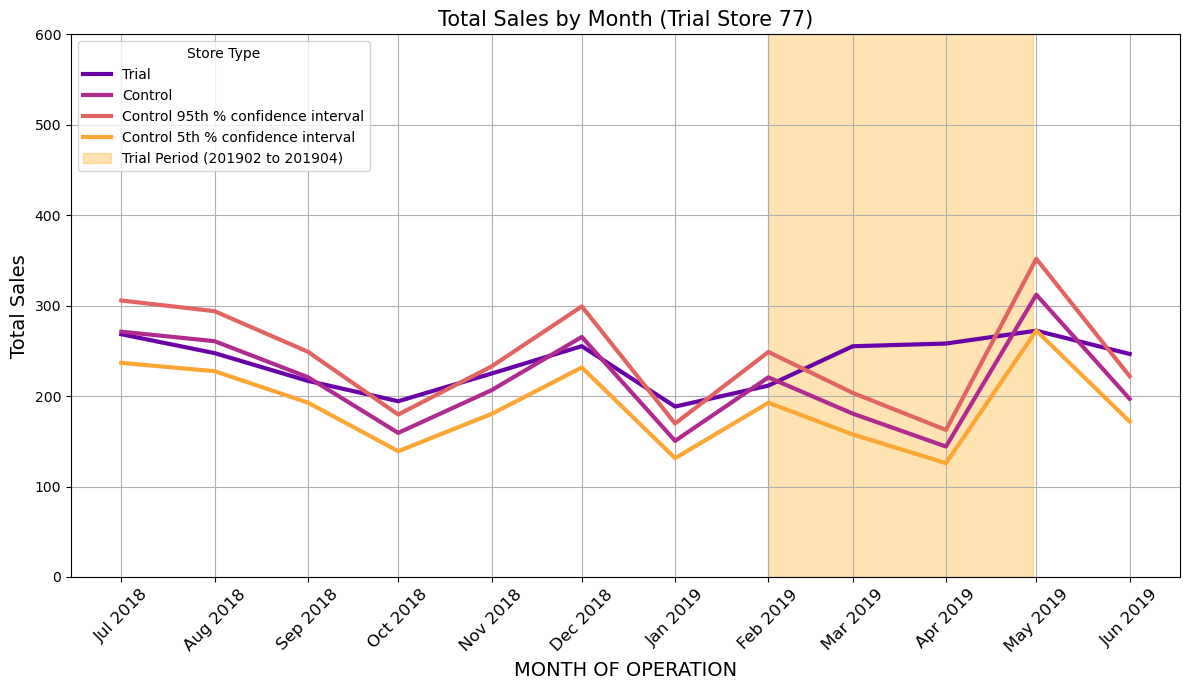

In [24]:
# Plot the sales data for the trial store and control stores
plot_data(
    trial_assessment,  
    metric='TOTAL_SALES',  
    y_label='Total Sales',  
    title=f'Total Sales by Month (Trial Store {trial_store})',
    ylim=(0,600) 
    )

#### Customers Data Analysis

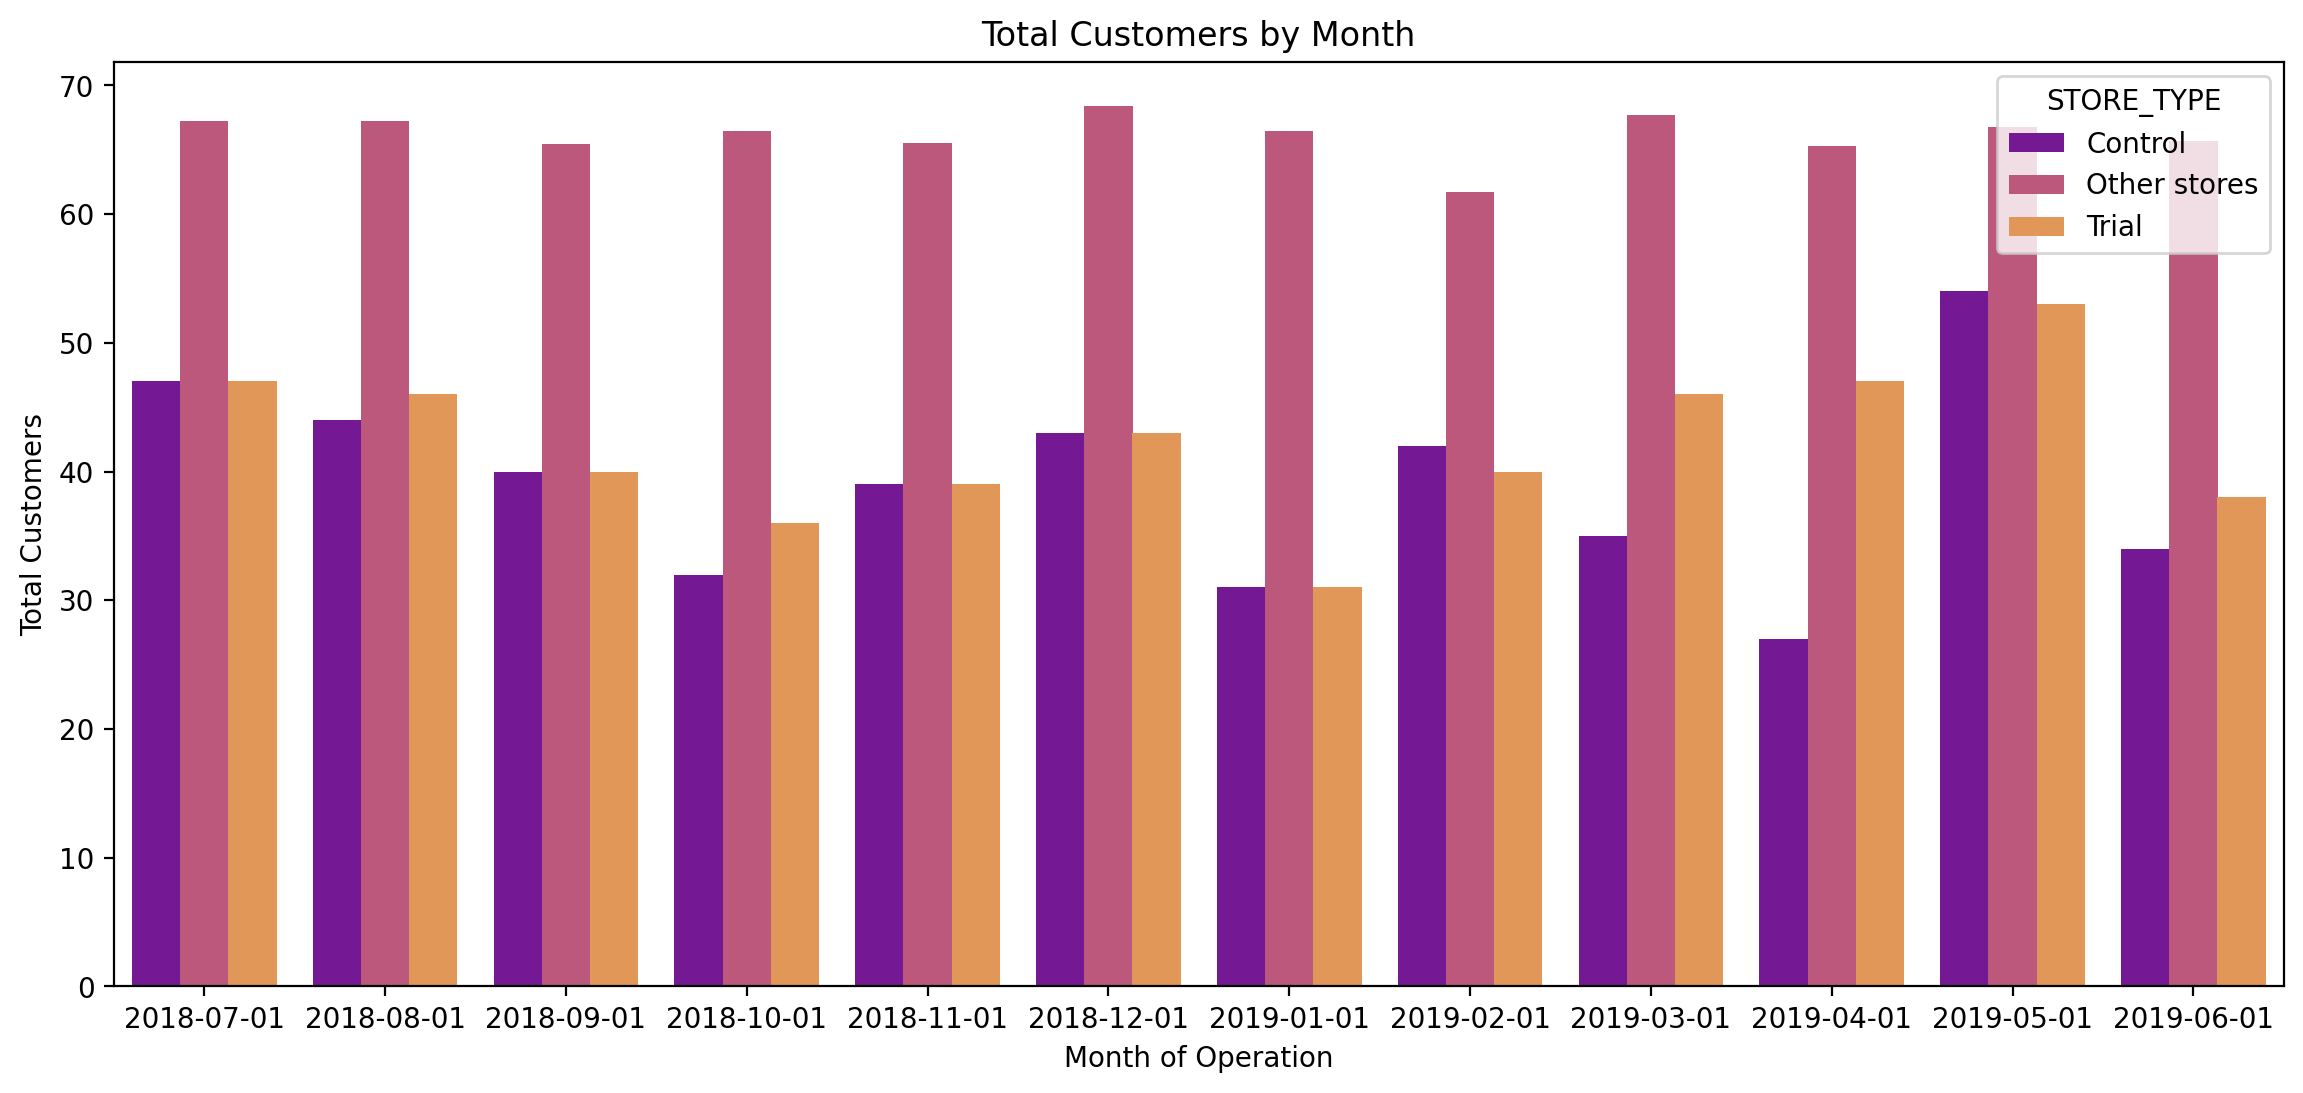

In [25]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_customers = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_customers = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['NUM_OF_CUSTOMERS'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_customers['TRANSACTION_MONTH'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_customers, 'NUM_OF_CUSTOMERS')

In [26]:
# Apply scaling factors for customers
trial_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
control_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
scaled_control_customers = apply_scaling_factor(measure_overtime, trial_customers, control_customers, 'CONTROL_CUSTOMERS_SUM', 'NUM_OF_CUSTOMERS', control_store)
scaled_control_customers

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS_SUM
2695,233,201807,271.2,47,1.04,1.68,3.43,48.0
2696,233,201808,260.7,44,1.02,1.64,3.62,45.0
2697,233,201809,220.9,40,1.08,1.70,3.25,40.9
2698,233,201810,159.3,32,1.00,1.50,3.32,32.7
2699,233,201811,206.5,39,1.03,1.56,3.39,39.8
2700,233,201812,265.4,43,1.05,1.63,3.79,43.9
2701,233,201901,150.5,31,1.00,1.32,3.67,31.7
2702,233,201902,220.7,42,1.02,1.52,3.45,42.9
2703,233,201903,180.6,35,1.03,1.49,3.47,35.8
2704,233,201904,144.2,27,1.07,1.52,3.52,27.6


In [27]:
# Calculate percentage difference 
percentage_difference_customers = calculate_percentage_difference(scaled_control_customers, trial_store, 'NUM_OF_CUSTOMERS', measure_overtime_customers)
percentage_difference_customers

,YEARMONTH,CONTROL_CUSTOMERS_SUM,TRIAL_CUSTOMERS,PERCENTAGE_DIFFERENCE
0,201807,48.0,47,0.020833
1,201808,45.0,46,0.022222
2,201809,40.9,40,0.022005
3,201810,32.7,36,0.100917
4,201811,39.8,39,0.020101
5,201812,43.9,43,0.020501
6,201901,31.7,31,0.022082
7,201902,42.9,40,0.067599
8,201903,35.8,46,0.284916
9,201904,27.6,47,0.702899


#### Hypothesis Testing

In [28]:
perform_hypothesis_test(percentage_difference_customers)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.030107855697612342
T-Critical Value: 1.894578605061305
201902: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
  YEARMONTH  CONTROL_CUSTOMERS_SUM  TRIAL_CUSTOMERS  PERCENTAGE_DIFFERENCE  \
7    201902                   42.9               40               0.067599   
8    201903                   35.8               46               0.284916   
9    201904                   27.6               47               0.702899   

      tValue  
7   2.245230  
8   9.463185  
9  23.346018  


#### Trial Assessment

In [29]:
# Trial Assessment: 
std_dev = percentage_difference_customers[percentage_difference_customers['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_customers, std_dev, metric='NUM_OF_CUSTOMERS')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,NUM_OF_CUSTOMERS
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,47.000000
2018-08-01,Trial,201808,46.000000
2018-09-01,Trial,201809,40.000000
2018-10-01,Trial,201810,36.000000
2018-11-01,Trial,201811,39.000000
2018-12-01,Trial,201812,43.000000
2019-01-01,Trial,201901,31.000000
2019-02-01,Trial,201902,40.000000
2019-03-01,Trial,201903,46.000000


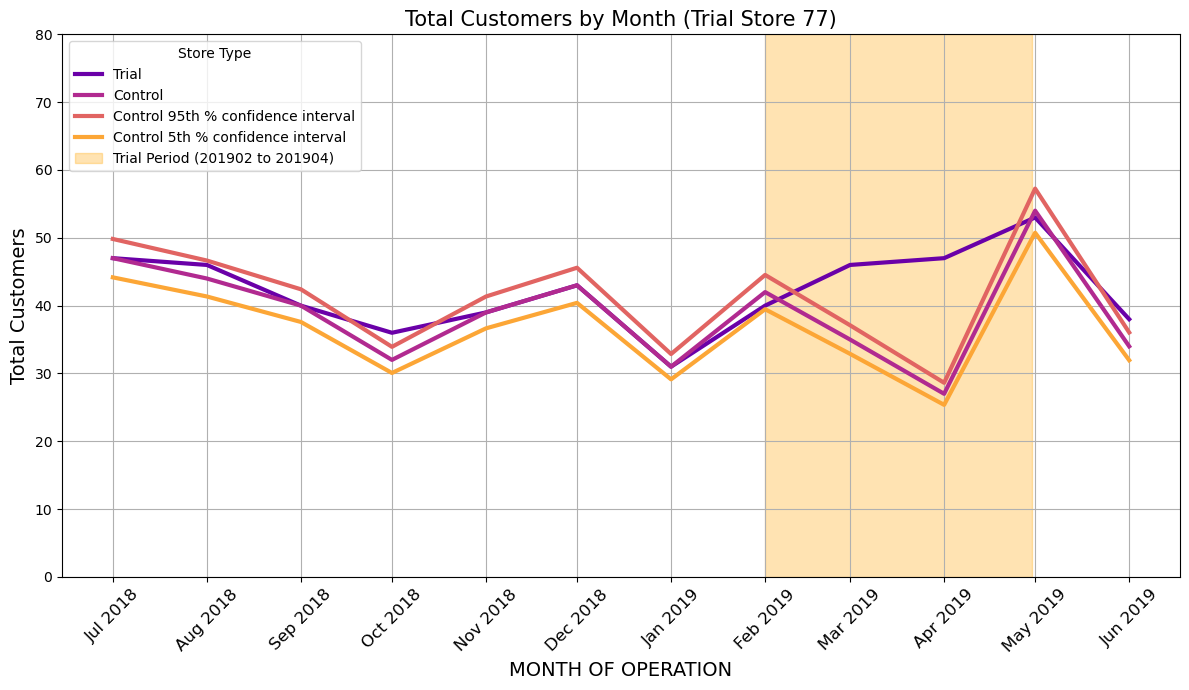

In [30]:
# Plot the data for NUM_OF_CUSTOMERS
plot_data(
        trial_assessment,  
        metric='NUM_OF_CUSTOMERS',  
        y_label='Total Customers',  
        title=f'Total Customers by Month (Trial Store {trial_store})',
        ylim=(0,80)  
    )

### Trial Store 86

In [31]:
trial_store = 86

In [32]:
# Calculate scores for each metric (Sales and Customers)
score_sales = calculate_scores_for_trial(pre_trial_measures, trial_store, 'TOTAL_SALES')
score_customers = calculate_scores_for_trial(pre_trial_measures, trial_store, 'NUM_OF_CUSTOMERS')
            
# Calculate final control store score
score_control = match_and_calculate_final_score(trial_store, score_sales, score_customers)
score_control

# Get the best matching control store based on the final score
control_store_row = score_control.loc[score_control.groupby('STORE_NBR_TRIAL')['FINAL_CONTROL_SCORE'].idxmax()]
control_store_row

,,WEIGHTED_SCORE_SALES,WEIGHTED_SCORE_CUSTOMERS,FINAL_CONTROL_SCORE
STORE_NBR_TRIAL,STORE_NBR_CONTROL,,,
86,155,0.91645,0.900597,0.908524


#### For Trial Store 86, the best matched Control Store is 155

#### Sales Data Analysis

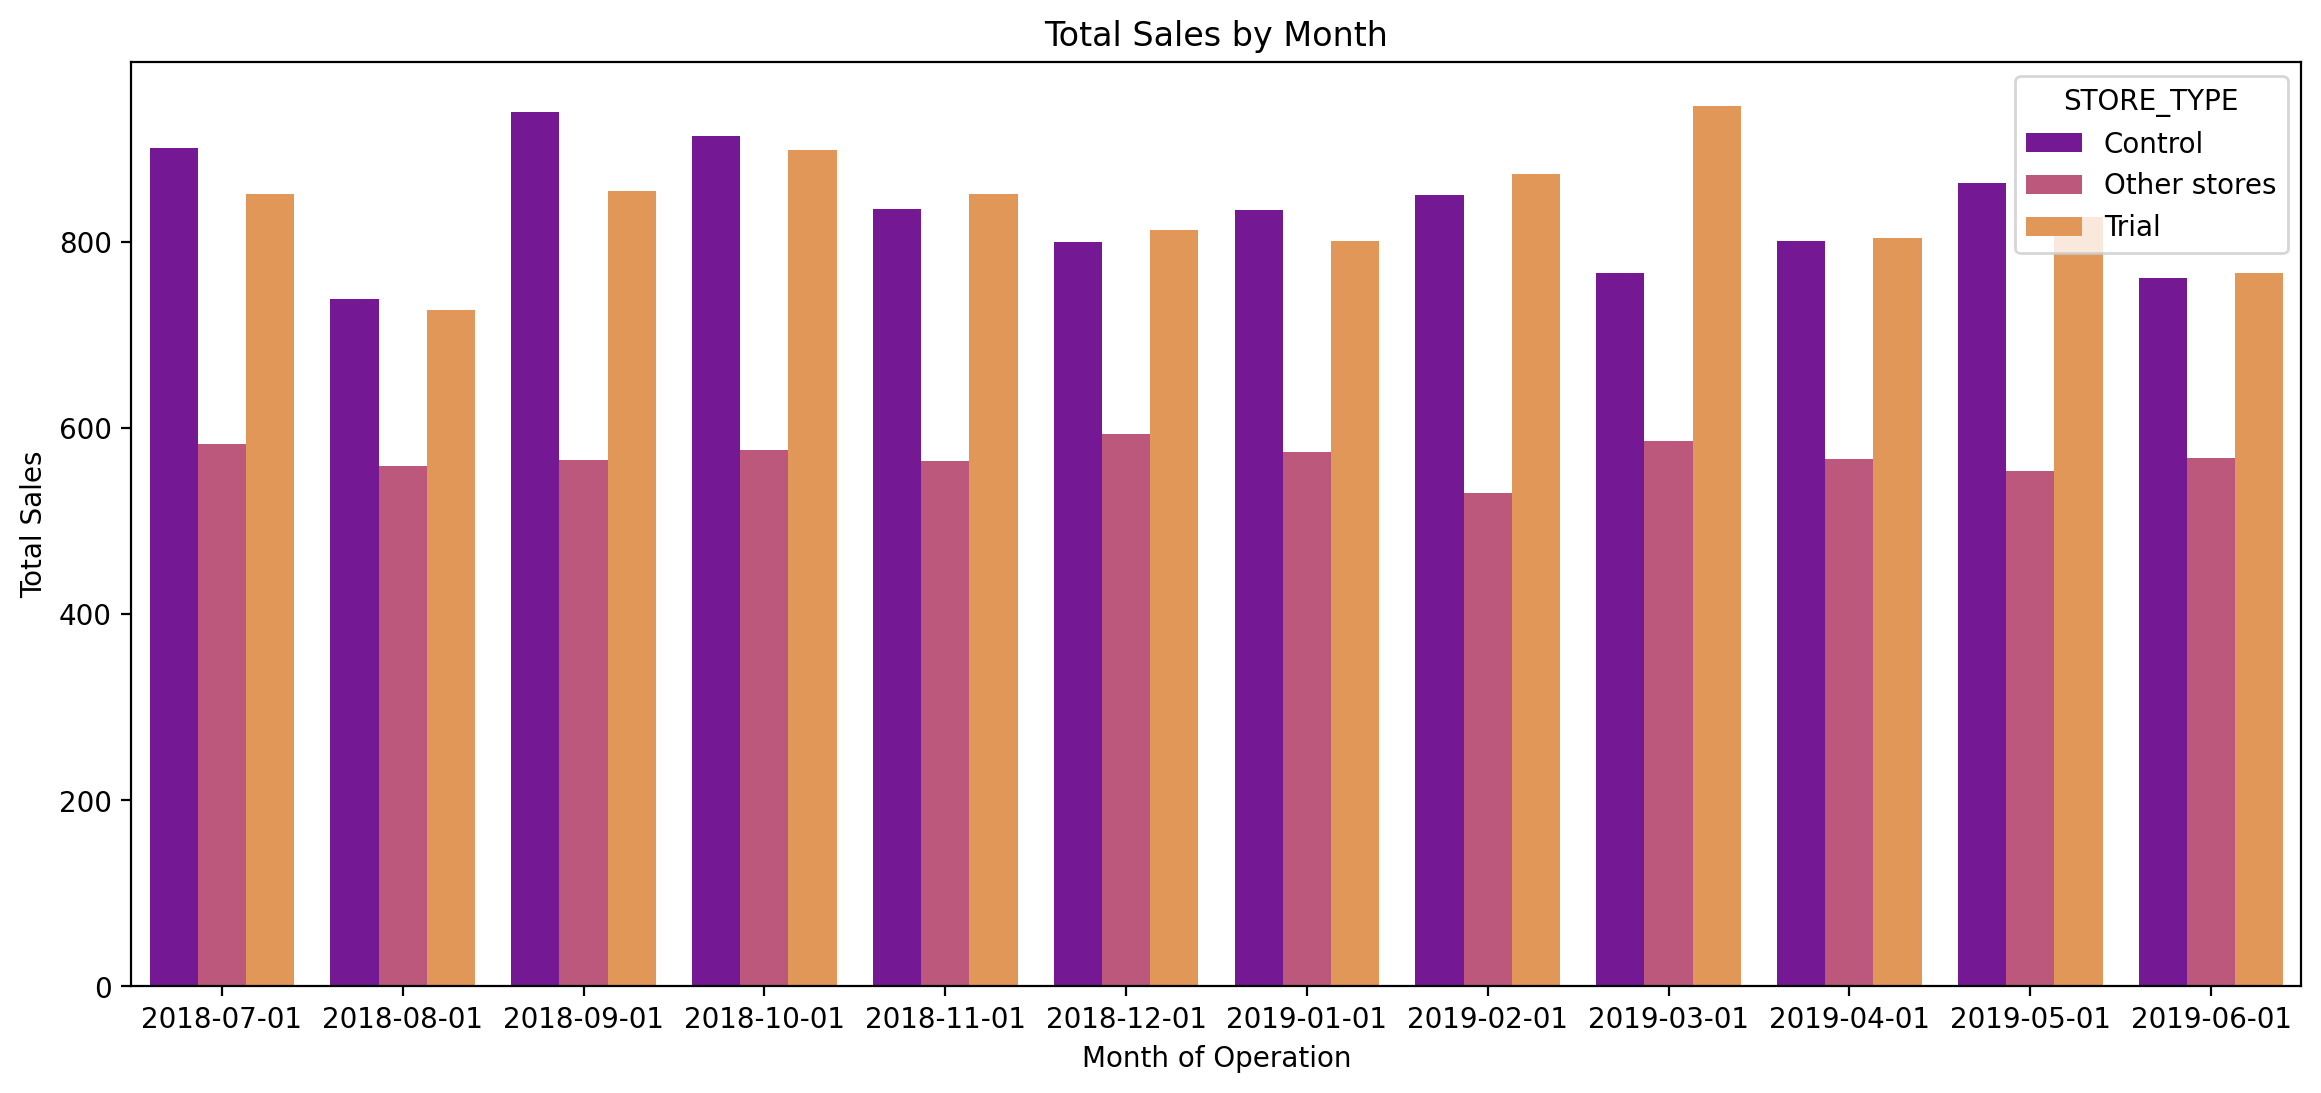

In [33]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_sales = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_sales = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['TOTAL_SALES'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_sales['TRANSACTION_MONTH'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_sales, 'TOTAL_SALES')

In [34]:
# Apply scaling factors for sales
trial_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
control_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
scaled_control_sales = apply_scaling_factor(measure_overtime_sales, trial_sales, control_sales, 'CONTROL_SALES_SUM', 'TOTAL_SALES', control_store)
scaled_control_sales

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,STORE_TYPE,CONTROL_SALES_SUM
1792,155,201807,900.60,98,1.22,2.45,3.75,Control,875.4
1793,155,201808,738.70,88,1.30,2.45,3.42,Control,718.1
1794,155,201809,939.60,96,1.36,2.73,3.59,Control,913.3
1795,155,201810,914.00,105,1.22,2.44,3.57,Control,888.5
1796,155,201811,835.00,96,1.29,2.58,3.37,Control,811.7
1797,155,201812,799.80,91,1.24,2.48,3.54,Control,777.4
1798,155,201901,834.60,92,1.28,2.57,3.54,Control,811.3
1799,155,201902,850.80,92,1.29,2.59,3.57,Control,827.0
1800,155,201903,767.00,91,1.23,2.46,3.42,Control,745.6
1801,155,201904,800.40,93,1.23,2.45,3.51,Control,778.0


In [35]:
# Calculate percentage difference 
percentage_difference_sales = calculate_percentage_difference(scaled_control_sales, trial_store, 'TOTAL_SALES', measure_overtime_sales)
percentage_difference_sales

,YEARMONTH,CONTROL_SALES_SUM,TRIAL_SALES,PERCENTAGE_DIFFERENCE
0,201807,875.4,851.00,0.027873
1,201808,718.1,726.85,0.012185
2,201809,913.3,855.00,0.063834
3,201810,888.5,898.80,0.011593
4,201811,811.7,851.20,0.048663
5,201812,777.4,812.20,0.044765
6,201901,811.3,800.60,0.013189
7,201902,827.0,872.80,0.055381
8,201903,745.6,945.40,0.267972
9,201904,778.0,804.00,0.033419


#### Hypothesis Testing

In [36]:
perform_hypothesis_test(percentage_difference_sales)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.020950396547484092
T-Critical Value: 1.894578605061305
201902: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Fail to Reject H0.
  YEARMONTH  CONTROL_SALES_SUM  TRIAL_SALES  PERCENTAGE_DIFFERENCE     tValue
7    201902              827.0        872.8               0.055381   2.643429
8    201903              745.6        945.4               0.267972  12.790789
9    201904              778.0        804.0               0.033419   1.595150


#### Trial Assessment

In [37]:
std_dev = percentage_difference_sales[percentage_difference_sales['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_sales, std_dev, metric='TOTAL_SALES')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,TOTAL_SALES
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,851.000000
2018-08-01,Trial,201808,726.850000
2018-09-01,Trial,201809,855.000000
2018-10-01,Trial,201810,898.800000
2018-11-01,Trial,201811,851.200000
2018-12-01,Trial,201812,812.200000
2019-01-01,Trial,201901,800.600000
2019-02-01,Trial,201902,872.800000
2019-03-01,Trial,201903,945.400000


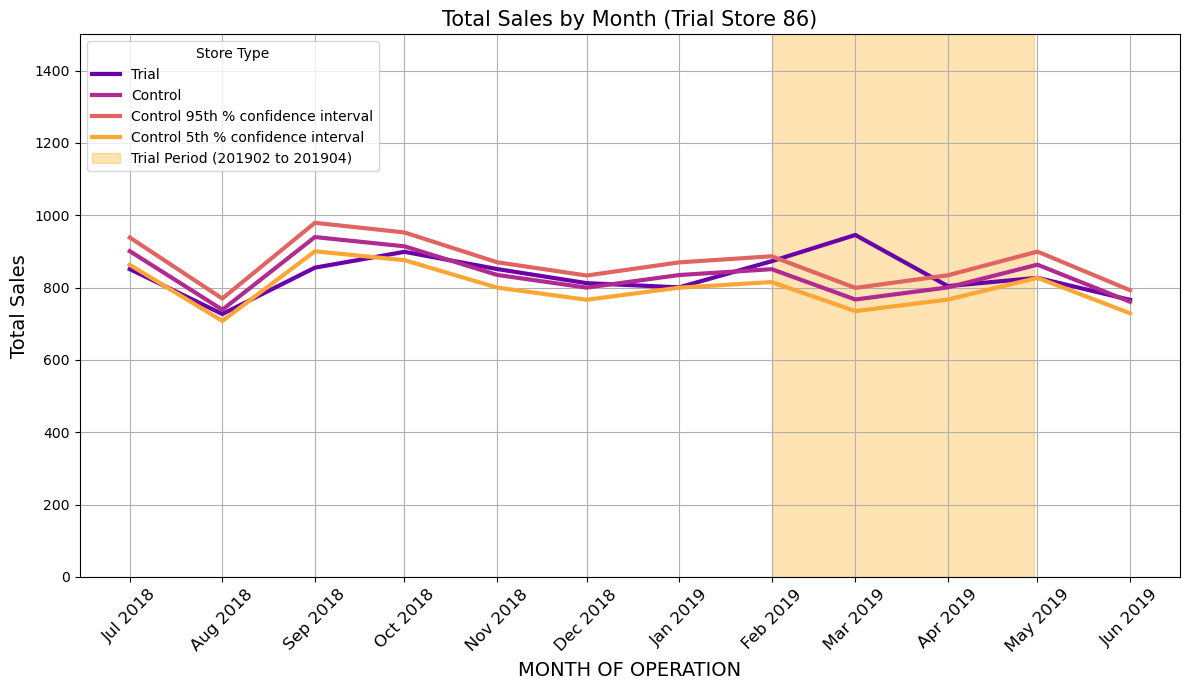

In [38]:
# Plot the sales data for the trial store and control stores
plot_data(
    trial_assessment,  
    metric='TOTAL_SALES',  
    y_label='Total Sales',  
    title=f'Total Sales by Month (Trial Store {trial_store})',
    ylim=(0,1500)  
    )

Despite of the significant increase in customer volume, the total sales for Trial Store 86 did not surpass the Control Store's 95th percentile in all 3 months. 

#### Customers Data Analysis

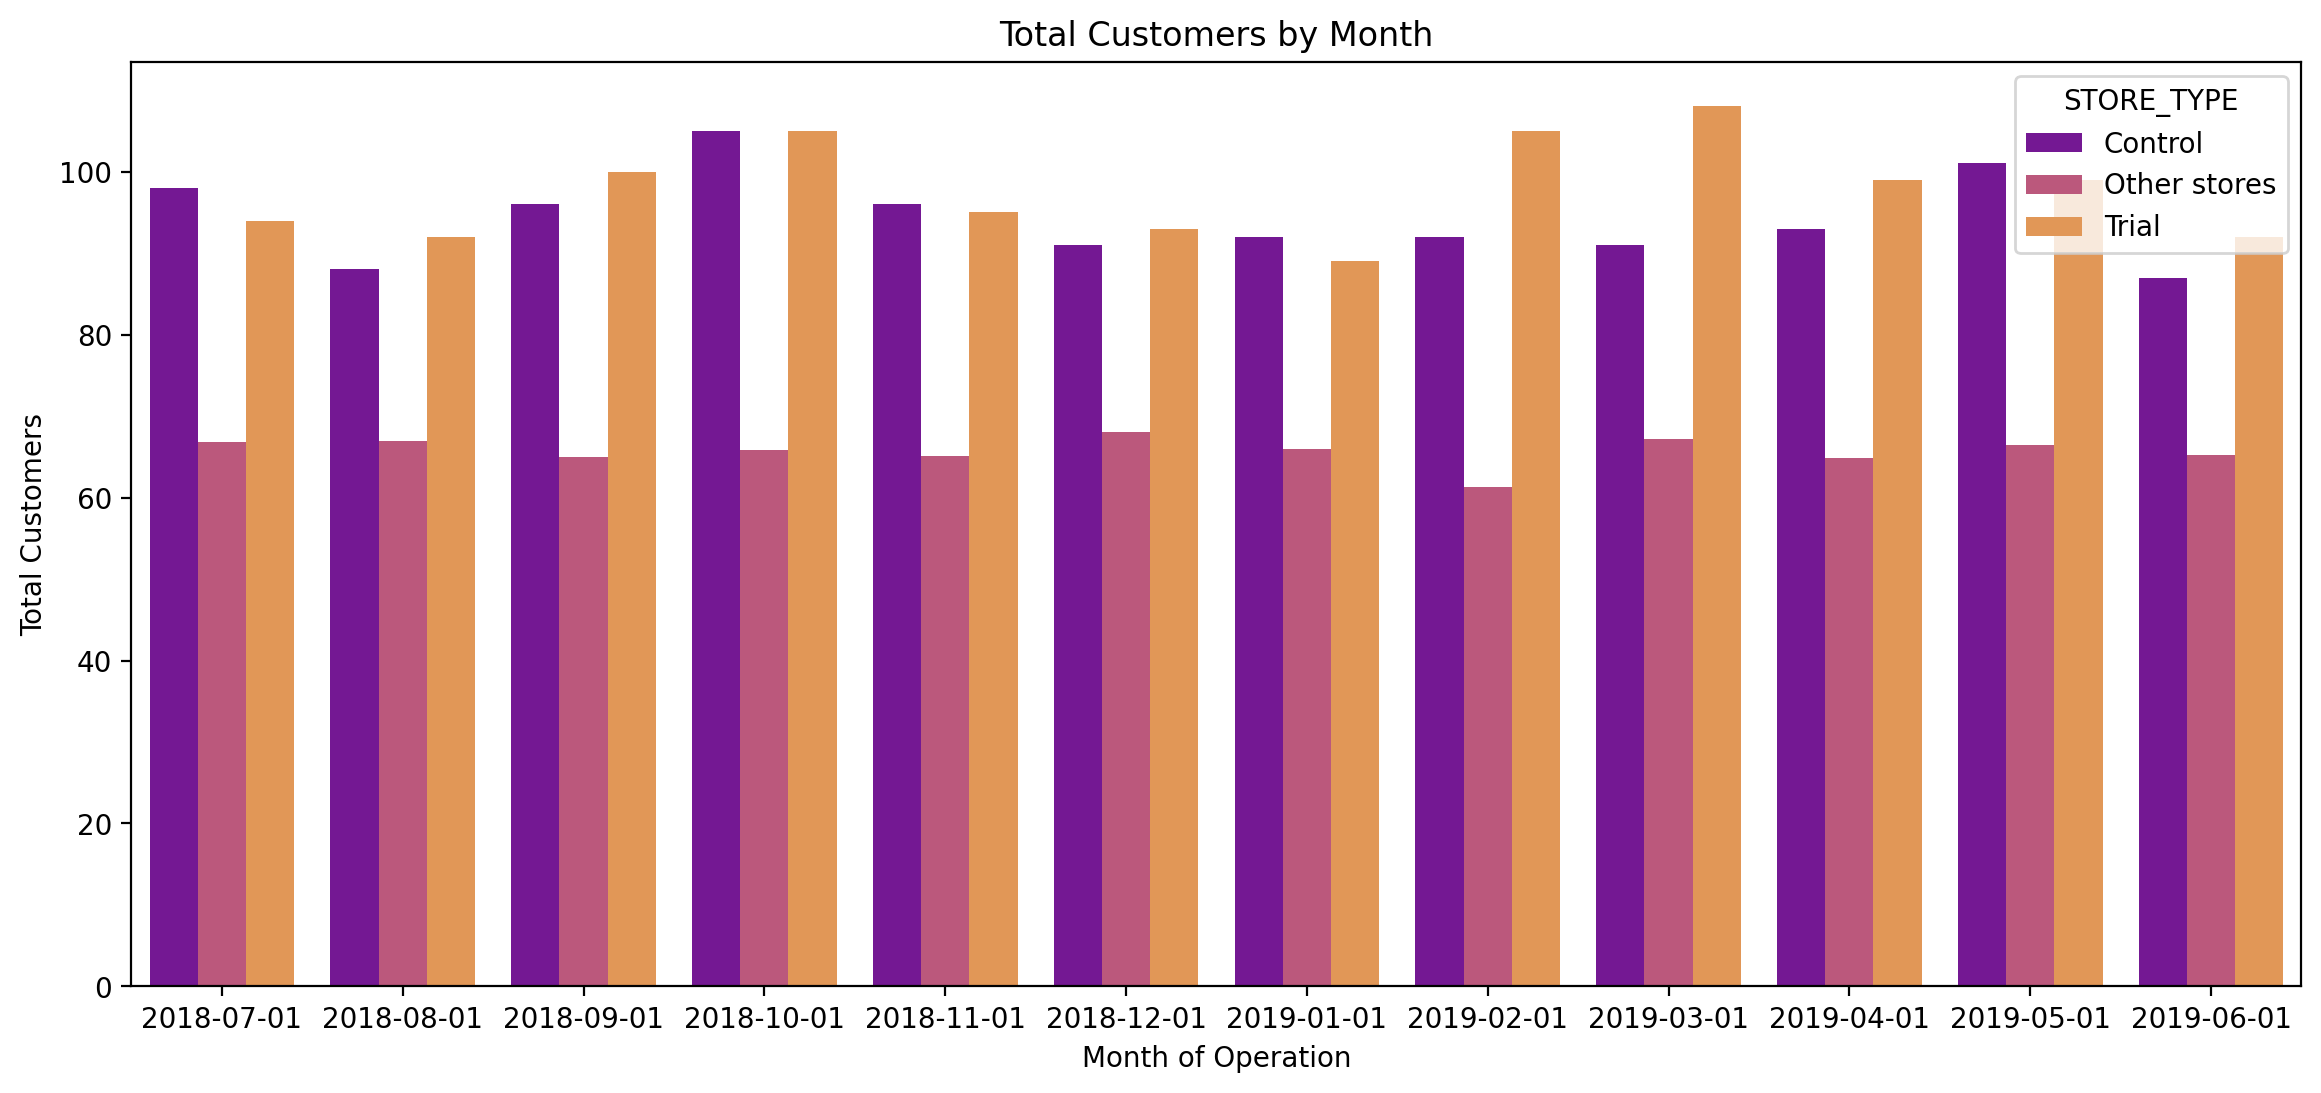

In [39]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_customers = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_customers = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['NUM_OF_CUSTOMERS'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_customers['TRANSACTION_MONTH'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_customers, 'NUM_OF_CUSTOMERS')

In [40]:
# Apply scaling factors for customers
trial_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
control_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
scaled_control_customers = apply_scaling_factor(measure_overtime, trial_customers, control_customers, 'CONTROL_CUSTOMERS_SUM', 'NUM_OF_CUSTOMERS', control_store)
scaled_control_customers

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS_SUM
1792,155,201807,900.60,98,1.22,2.45,3.75,98.3
1793,155,201808,738.70,88,1.30,2.45,3.42,88.3
1794,155,201809,939.60,96,1.36,2.73,3.59,96.3
1795,155,201810,914.00,105,1.22,2.44,3.57,105.3
1796,155,201811,835.00,96,1.29,2.58,3.37,96.3
1797,155,201812,799.80,91,1.24,2.48,3.54,91.3
1798,155,201901,834.60,92,1.28,2.57,3.54,92.3
1799,155,201902,850.80,92,1.29,2.59,3.57,92.3
1800,155,201903,767.00,91,1.23,2.46,3.42,91.3
1801,155,201904,800.40,93,1.23,2.45,3.51,93.3


In [41]:
# Calculate percentage difference 
percentage_difference_customers = calculate_percentage_difference(scaled_control_customers, trial_store, 'NUM_OF_CUSTOMERS', measure_overtime_customers)
percentage_difference_customers

,YEARMONTH,CONTROL_CUSTOMERS_SUM,TRIAL_CUSTOMERS,PERCENTAGE_DIFFERENCE
0,201807,98.3,94,0.043744
1,201808,88.3,92,0.041903
2,201809,96.3,100,0.038422
3,201810,105.3,105,0.002849
4,201811,96.3,95,0.013499
5,201812,91.3,93,0.018620
6,201901,92.3,89,0.035753
7,201902,92.3,105,0.137595
8,201903,91.3,108,0.182913
9,201904,93.3,99,0.061093


#### Hypothesis Testing

In [42]:
perform_hypothesis_test(percentage_difference_customers)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.016023300886540606
T-Critical Value: 1.894578605061305
201902: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
  YEARMONTH  CONTROL_CUSTOMERS_SUM  TRIAL_CUSTOMERS  PERCENTAGE_DIFFERENCE  \
7    201902                   92.3              105               0.137595   
8    201903                   91.3              108               0.182913   
9    201904                   93.3               99               0.061093   

      tValue  
7   8.587169  
8  11.415468  
9   3.812775  


#### Trial Assessment

In [43]:
# Trial Assessment: 
std_dev = percentage_difference_customers[percentage_difference_customers['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_customers, std_dev, metric='NUM_OF_CUSTOMERS')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,NUM_OF_CUSTOMERS
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,94.000000
2018-08-01,Trial,201808,92.000000
2018-09-01,Trial,201809,100.000000
2018-10-01,Trial,201810,105.000000
2018-11-01,Trial,201811,95.000000
2018-12-01,Trial,201812,93.000000
2019-01-01,Trial,201901,89.000000
2019-02-01,Trial,201902,105.000000
2019-03-01,Trial,201903,108.000000


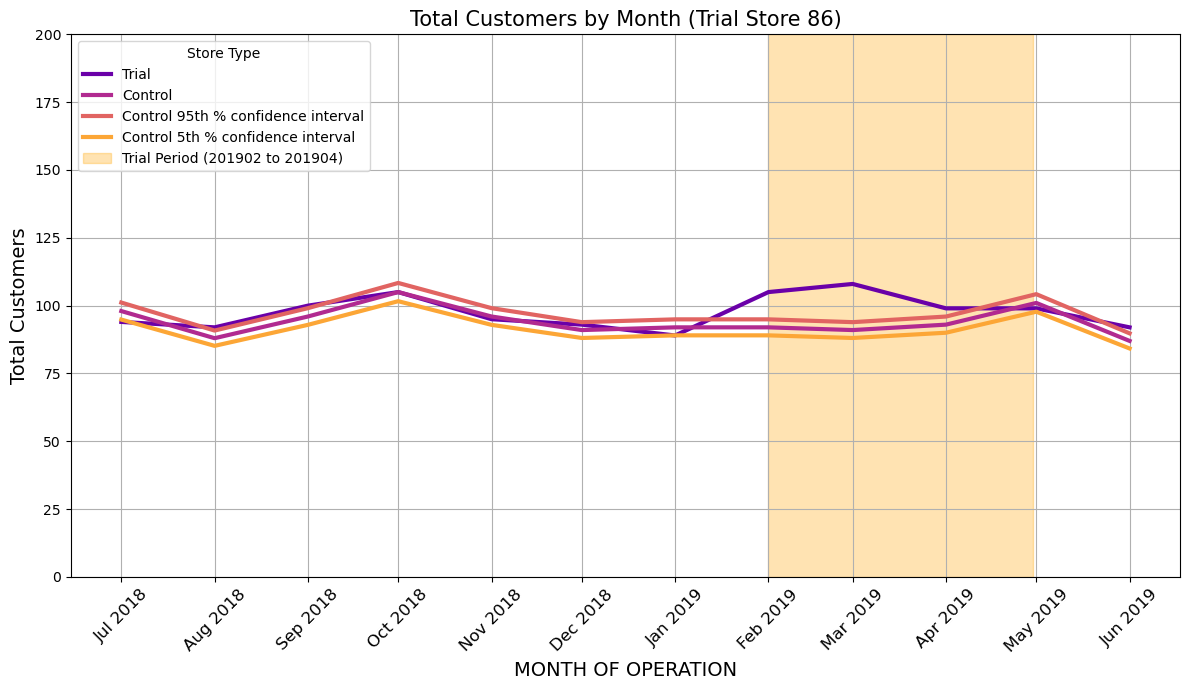

In [44]:
# Plot the data for NUM_OF_CUSTOMERS
plot_data(
        trial_assessment,  
        metric='NUM_OF_CUSTOMERS',  
        y_label='Total Customers',  
        title=f'Total Customers by Month (Trial Store {trial_store})',
        ylim=(0,200)  
    )

It looks like the number of customers is significantly higher in all of the three
months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not
significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices,
impacting the results.

### Trial Store 88

In [45]:
trial_store = 88

In [46]:
# Calculate scores for each metric (Sales and Customers)
score_sales = calculate_scores_for_trial(pre_trial_measures, trial_store, 'TOTAL_SALES')
score_customers = calculate_scores_for_trial(pre_trial_measures, trial_store, 'NUM_OF_CUSTOMERS')
            
# Calculate final control store score
score_control = match_and_calculate_final_score(trial_store, score_sales, score_customers)
score_control

# Get the best matching control store based on the final score
control_store_row = score_control.loc[score_control.groupby('STORE_NBR_TRIAL')['FINAL_CONTROL_SCORE'].idxmax()]
control_store_row

,,WEIGHTED_SCORE_SALES,WEIGHTED_SCORE_CUSTOMERS,FINAL_CONTROL_SCORE
STORE_NBR_TRIAL,STORE_NBR_CONTROL,,,
88,237,0.529452,0.97042,0.749936


#### For Trial Store 88, the best matched Control Store is 237

#### Sales Data Analysis

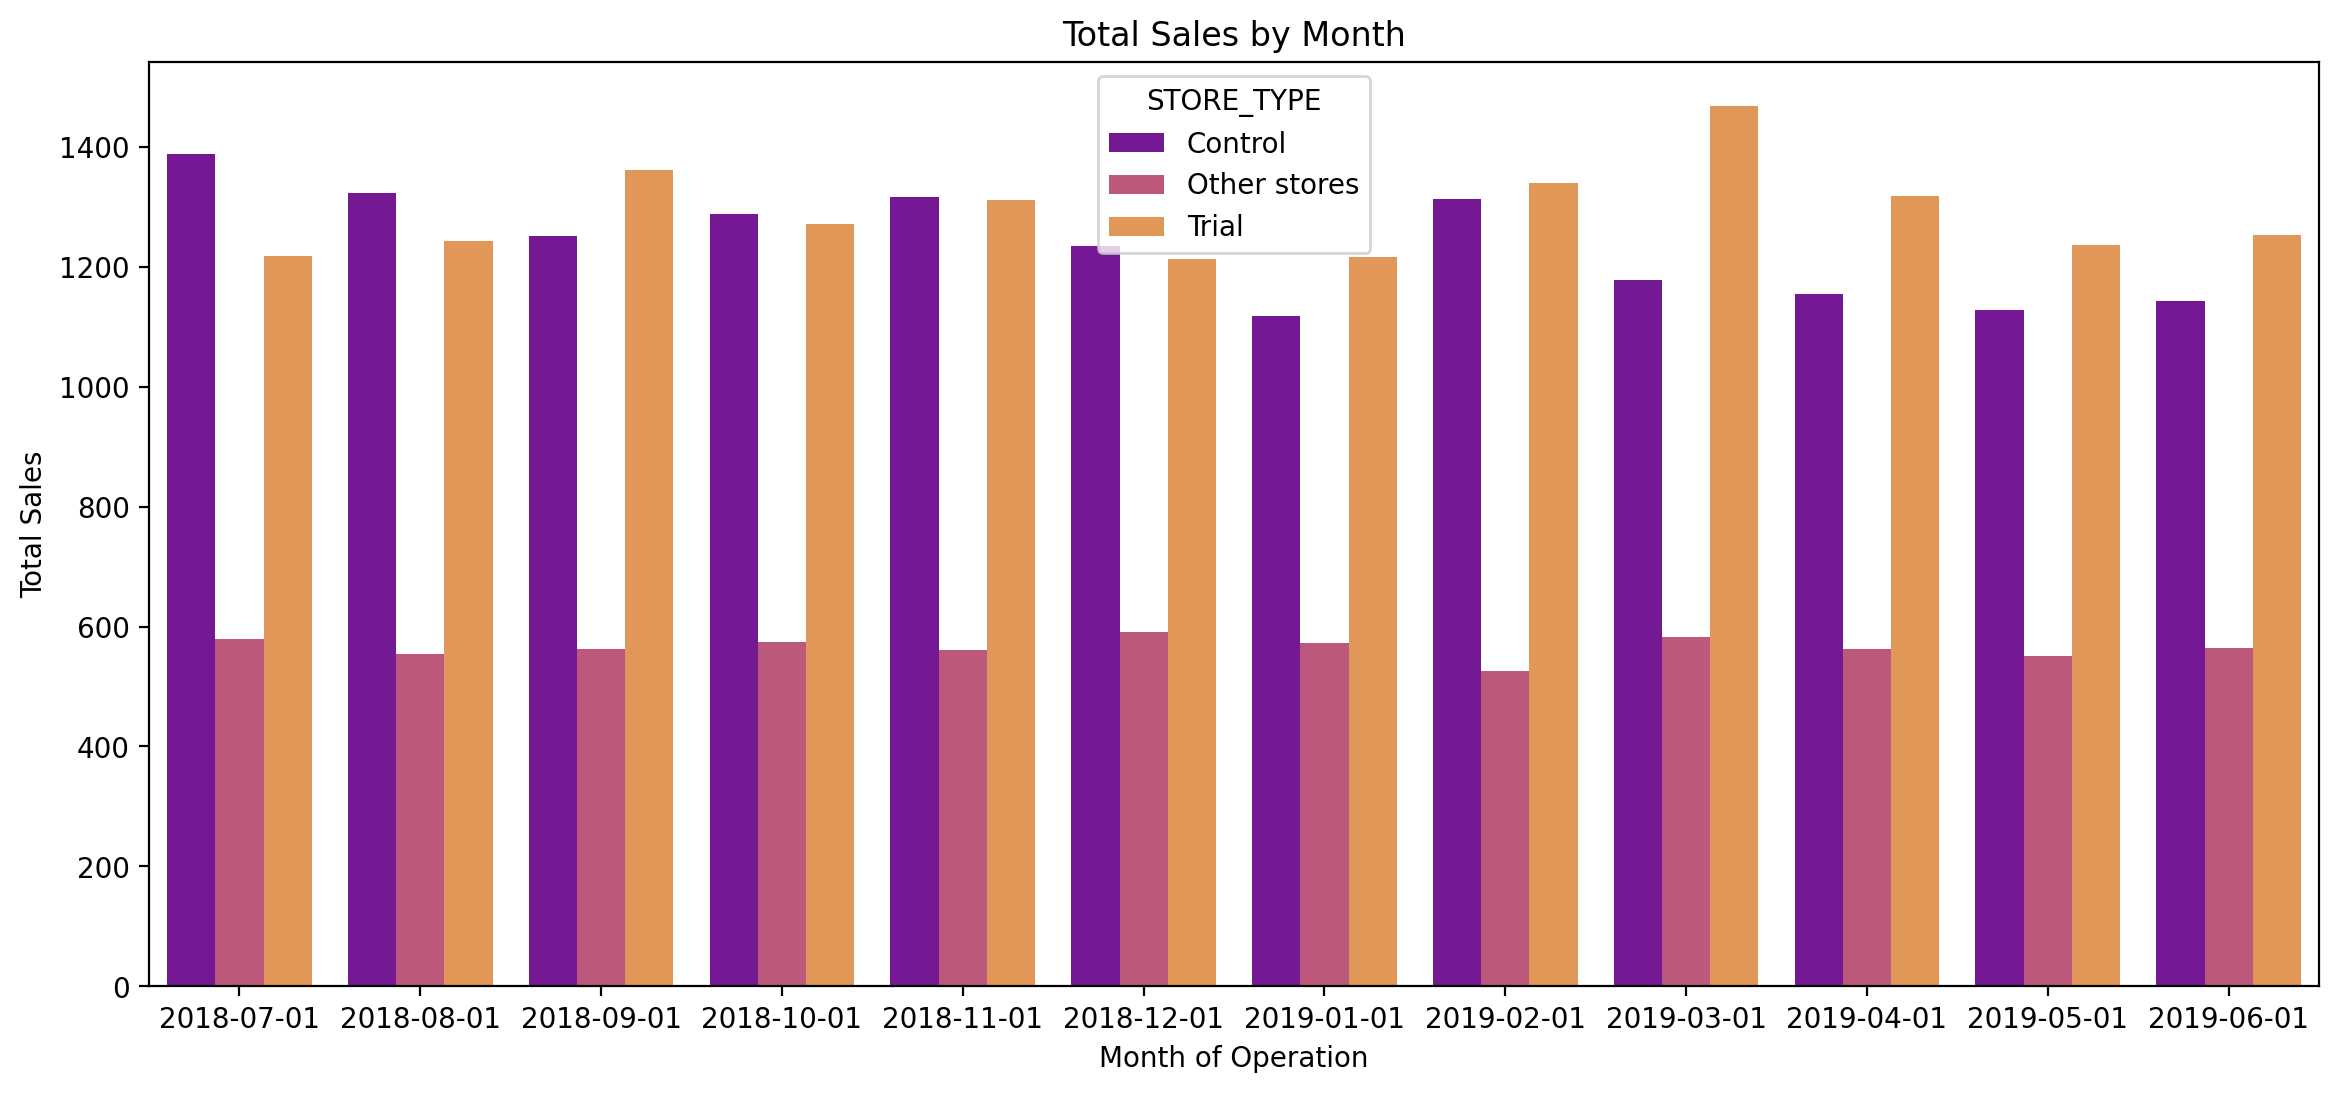

In [47]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_sales = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_sales = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['TOTAL_SALES'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_sales['TRANSACTION_MONTH'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_sales, 'TOTAL_SALES')

In [48]:
# Apply scaling factors for sales so control and trial stores are comparable during the trial period 
trial_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
control_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['TOTAL_SALES'].sum()
scaled_control_sales = apply_scaling_factor(measure_overtime_sales, trial_sales, control_sales, 'CONTROL_SALES_SUM', 'TOTAL_SALES', control_store)
scaled_control_sales

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,STORE_TYPE,CONTROL_SALES_SUM
2743,237,201807,1387.2,125,1.25,2.50,4.45,Control,1374.4
2744,237,201808,1321.9,132,1.22,2.30,4.35,Control,1309.7
2745,237,201809,1250.8,120,1.19,2.38,4.39,Control,1239.3
2746,237,201810,1287.1,118,1.22,2.43,4.48,Control,1275.2
2747,237,201811,1316.0,125,1.22,2.43,4.33,Control,1303.9
2748,237,201812,1234.4,121,1.17,2.34,4.36,Control,1223.0
2749,237,201901,1117.7,111,1.16,2.32,4.35,Control,1107.4
2750,237,201902,1313.0,119,1.24,2.49,4.44,Control,1300.9
2751,237,201903,1177.6,116,1.16,2.31,4.39,Control,1166.7
2752,237,201904,1153.6,116,1.13,2.26,4.40,Control,1143.0


In [49]:
# Calculate percentage difference between sales for scaled control & trial stores 
percentage_difference_sales = calculate_percentage_difference(scaled_control_sales, trial_store, 'TOTAL_SALES', measure_overtime_sales)
percentage_difference_sales

,YEARMONTH,CONTROL_SALES_SUM,TRIAL_SALES,PERCENTAGE_DIFFERENCE
0,201807,1374.4,1218.20,0.113650
1,201808,1309.7,1242.20,0.051539
2,201809,1239.3,1361.80,0.098846
3,201810,1275.2,1270.80,0.003450
4,201811,1303.9,1311.40,0.005752
5,201812,1223.0,1213.00,0.008177
6,201901,1107.4,1215.40,0.097526
7,201902,1300.9,1339.60,0.029749
8,201903,1166.7,1467.00,0.257393
9,201904,1143.0,1317.00,0.152231


#### Hypothesis Testing

In [50]:
perform_hypothesis_test(percentage_difference_sales)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.049079160365275945
T-Critical Value: 1.894578605061305
201902: Fail to Reject H0.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
  YEARMONTH  CONTROL_SALES_SUM  TRIAL_SALES  PERCENTAGE_DIFFERENCE    tValue
7    201902             1300.9       1339.6               0.029749  0.606136
8    201903             1166.7       1467.0               0.257393  5.244439
9    201904             1143.0       1317.0               0.152231  3.101744


#### Trial Assessment

In [51]:
std_dev = percentage_difference_sales[percentage_difference_sales['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_sales, std_dev, metric='TOTAL_SALES')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,TOTAL_SALES
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,1218.200000
2018-08-01,Trial,201808,1242.200000
2018-09-01,Trial,201809,1361.800000
2018-10-01,Trial,201810,1270.800000
2018-11-01,Trial,201811,1311.400000
2018-12-01,Trial,201812,1213.000000
2019-01-01,Trial,201901,1215.400000
2019-02-01,Trial,201902,1339.600000
2019-03-01,Trial,201903,1467.000000


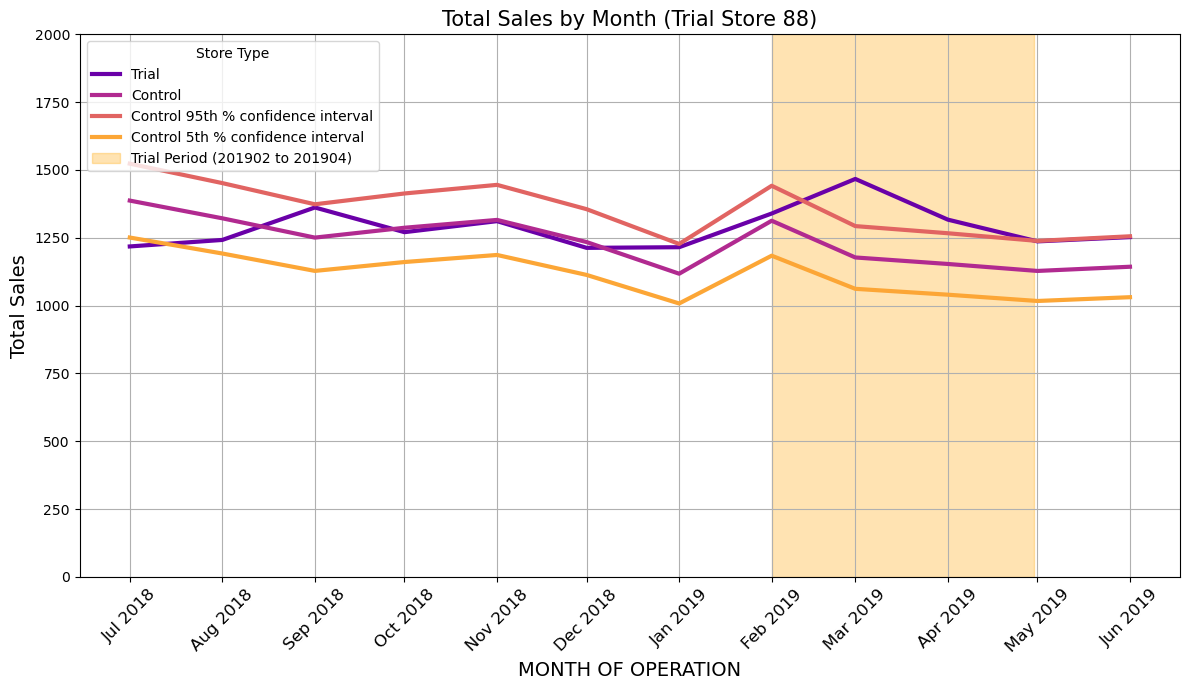

In [52]:
# Plot the sales data for the trial store and control stores
plot_data(
    trial_assessment,  
    metric='TOTAL_SALES',  
    y_label='Total Sales',  
    title=f'Total Sales by Month (Trial Store {trial_store})',
    ylim=(0,2000) 
    )

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.

#### Customers Data Analysis

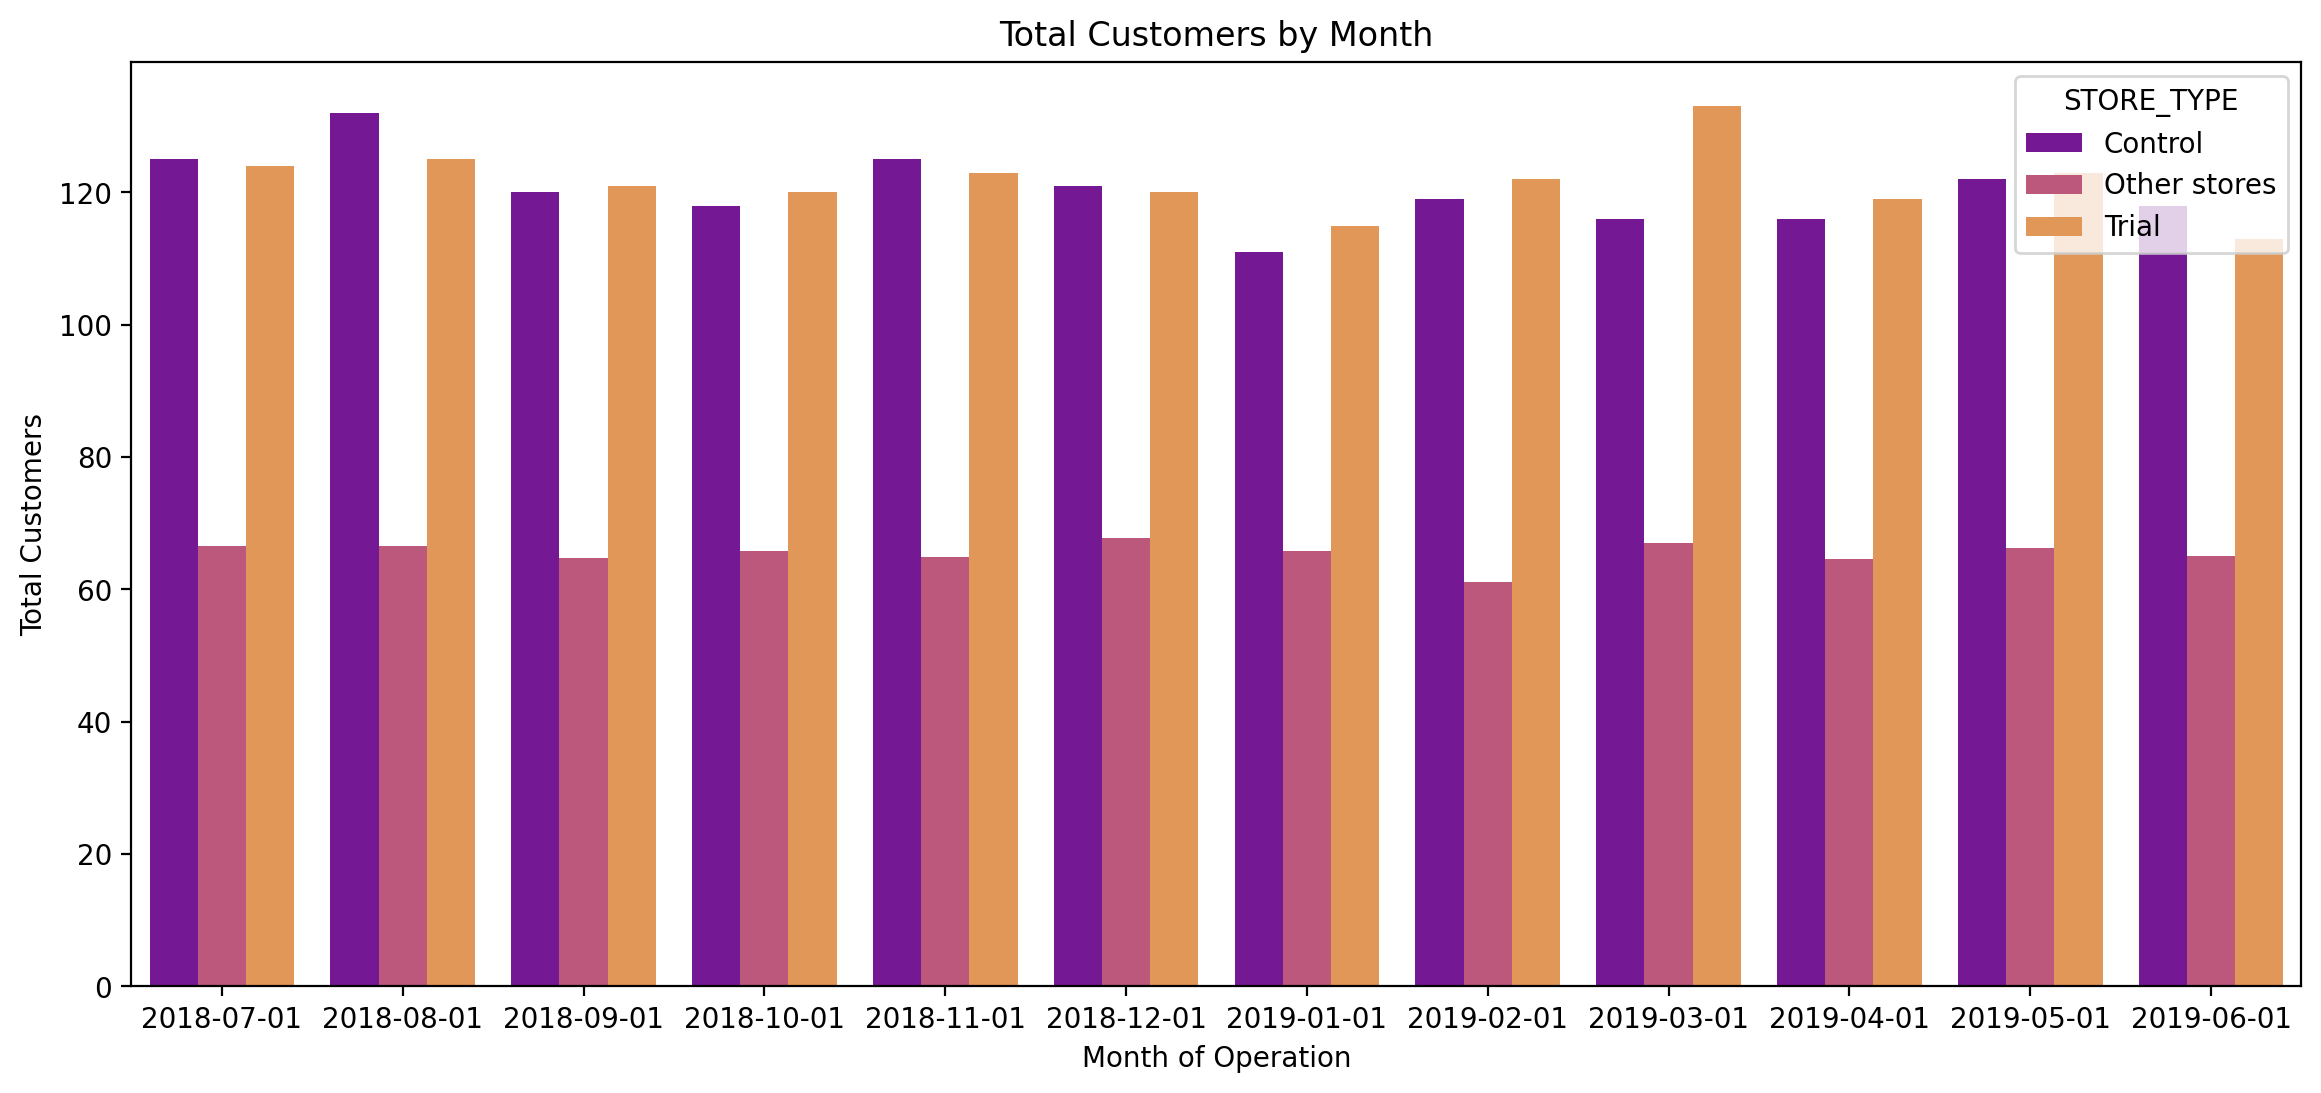

In [53]:
control_store = control_store_row.index.get_level_values('STORE_NBR_CONTROL').tolist()
# Assign store types ('Trial', 'Control', 'Other') to the measure_overtime_sales dataset
measure_overtime_customers = assign_store_types(measure_overtime.copy(), trial_store, control_store)
    
# Group and calculate the mean of 'TOTAL_SALES' for each store type and month
past_customers = measure_overtime_sales.groupby(['YEARMONTH', 'STORE_TYPE'])['NUM_OF_CUSTOMERS'].mean().reset_index()

# Convert 'YEARMONTH' to a datetime object
past_customers['TRANSACTION_MONTH'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plot_metric_by_month(past_customers, 'NUM_OF_CUSTOMERS')

In [54]:
# Apply scaling factors for customers
trial_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
control_customers = pre_trial_measures[(pre_trial_measures['STORE_NBR'].isin(control_store)) & (pre_trial_measures['YEARMONTH'] < '201902')]['NUM_OF_CUSTOMERS'].sum()
scaled_control_customers = apply_scaling_factor(measure_overtime, trial_customers, control_customers, 'CONTROL_CUSTOMERS_SUM', 'NUM_OF_CUSTOMERS', control_store)
scaled_control_customers

,STORE_NBR,YEARMONTH,TOTAL_SALES,NUM_OF_CUSTOMERS,TRANSACTIONS_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS_SUM
2743,237,201807,1387.2,125,1.25,2.50,4.45,124.4
2744,237,201808,1321.9,132,1.22,2.30,4.35,131.4
2745,237,201809,1250.8,120,1.19,2.38,4.39,119.4
2746,237,201810,1287.1,118,1.22,2.43,4.48,117.4
2747,237,201811,1316.0,125,1.22,2.43,4.33,124.4
2748,237,201812,1234.4,121,1.17,2.34,4.36,120.4
2749,237,201901,1117.7,111,1.16,2.32,4.35,110.5
2750,237,201902,1313.0,119,1.24,2.49,4.44,118.4
2751,237,201903,1177.6,116,1.16,2.31,4.39,115.5
2752,237,201904,1153.6,116,1.13,2.26,4.40,115.5


In [55]:
# Calculate percentage difference 
percentage_difference_customers = calculate_percentage_difference(scaled_control_customers, trial_store, 'NUM_OF_CUSTOMERS', measure_overtime_customers)
percentage_difference_customers

,YEARMONTH,CONTROL_CUSTOMERS_SUM,TRIAL_CUSTOMERS,PERCENTAGE_DIFFERENCE
0,201807,124.4,124,0.003215
1,201808,131.4,125,0.048706
2,201809,119.4,121,0.013400
3,201810,117.4,120,0.022147
4,201811,124.4,123,0.011254
5,201812,120.4,120,0.003322
6,201901,110.5,115,0.040724
7,201902,118.4,122,0.030405
8,201903,115.5,133,0.151515
9,201904,115.5,119,0.030303


#### Hypothesis Testing

In [56]:
perform_hypothesis_test(percentage_difference_customers)

H0: trial - pre_trial = 0 | Ha: trial - pre_trial =/= 0
Degree of Freedom: 7 | alpha = 0.05 | std_dev = 0.017967379944439074
T-Critical Value: 1.894578605061305
201902: Fail to Reject H0.
201903: Reject H0. There is sufficient evidence to conclude that sales/customers differ.
201904: Fail to Reject H0.
  YEARMONTH  CONTROL_CUSTOMERS_SUM  TRIAL_CUSTOMERS  PERCENTAGE_DIFFERENCE  \
7    201902                  118.4              122               0.030405   
8    201903                  115.5              133               0.151515   
9    201904                  115.5              119               0.030303   

     tValue  
7  1.692256  
8  8.432791  
9  1.686558  


#### Trial Assessment

In [57]:
# Trial Assessment: 
std_dev = percentage_difference_customers[percentage_difference_customers['YEARMONTH'] < '201902']['PERCENTAGE_DIFFERENCE'].std()
trial_assessment = create_trial_assessment(measure_overtime_customers, std_dev, metric='NUM_OF_CUSTOMERS')
trial_assessment

/var/folders/7m/wfwdc8s14pgch1s3hgyyg6080000gn/T/ipykernel_95955/778200519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['TRANSACTION_MONTH'] = pd.to_datetime(past_data['YEARMONTH'].astype(str), format='%Y%m')


,STORE_TYPE,YEARMONTH,NUM_OF_CUSTOMERS
TRANSACTION_MONTH,,,
2018-07-01,Trial,201807,124.000000
2018-08-01,Trial,201808,125.000000
2018-09-01,Trial,201809,121.000000
2018-10-01,Trial,201810,120.000000
2018-11-01,Trial,201811,123.000000
2018-12-01,Trial,201812,120.000000
2019-01-01,Trial,201901,115.000000
2019-02-01,Trial,201902,122.000000
2019-03-01,Trial,201903,133.000000


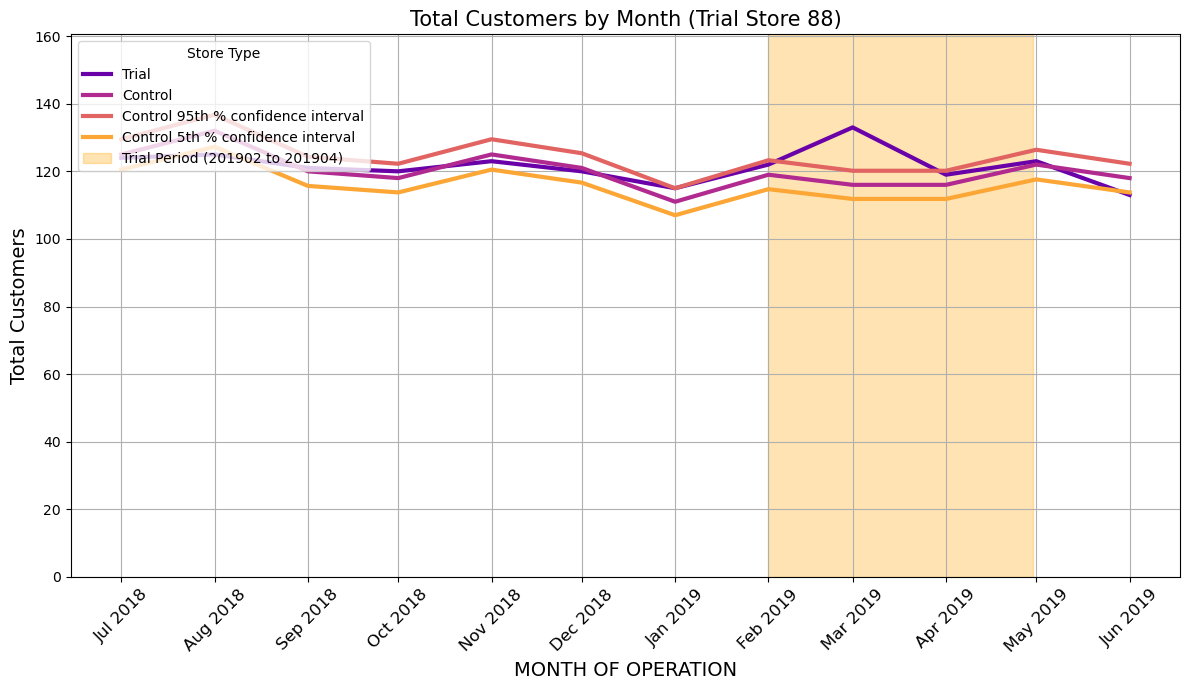

In [58]:
# Plot the data for NUM_OF_CUSTOMERS
plot_data(
        trial_assessment,  
        metric='NUM_OF_CUSTOMERS',  
        y_label='Total Customers',  
        title=f'Total Customers by Month (Trial Store {trial_store})'  
    )

### Overall Sales Performance

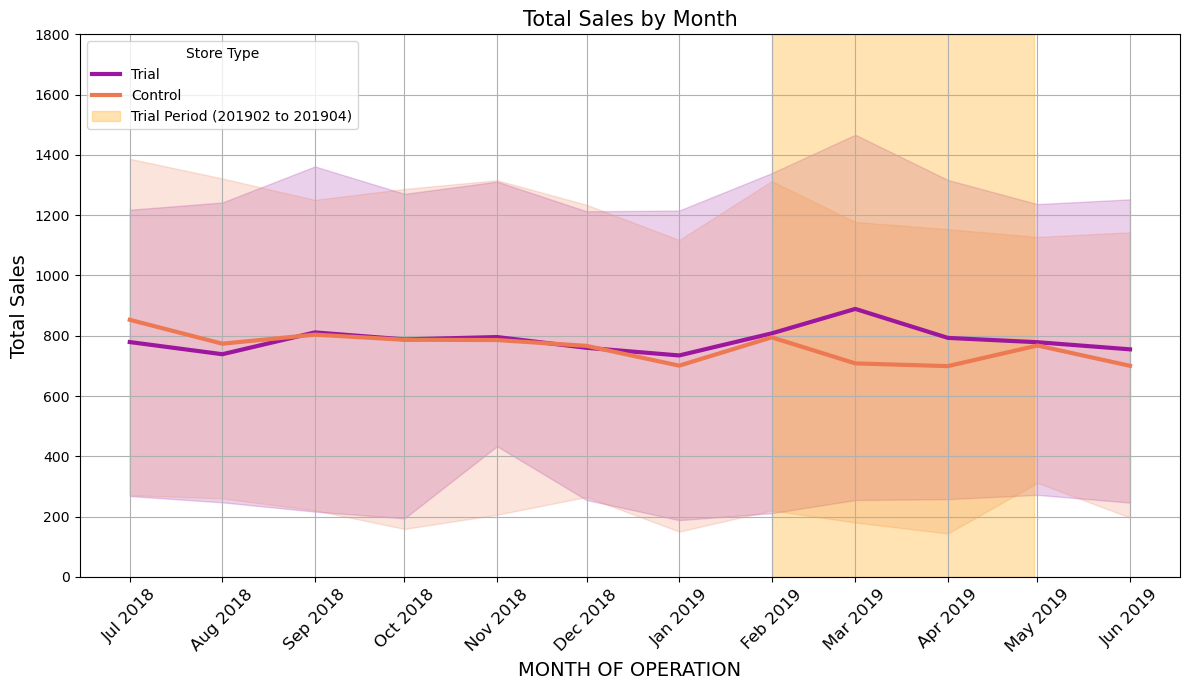

In [59]:
trial_control = [77, 233, 86, 155, 88, 237]

# Filter the data for the selected stores
all_sales = measure_overtime_sales[measure_overtime_sales['STORE_NBR'].isin(trial_control)][['STORE_NBR','TOTAL_SALES','NUM_OF_CUSTOMERS','YEARMONTH']]

all_sales['TRANSACTION_MONTH'] = pd.to_datetime(all_sales['YEARMONTH'].astype(str), format='%Y%m')

all_sales['STORE_TYPE'] = all_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x in [77, 86, 88] else 'Control')

plot_data(
    all_sales,  
    metric='TOTAL_SALES',  
    y_label='Total Sales',  
    title=f'Total Sales by Month', ylim=(0,1800)
)


### Summary of Insights

1. In Pre-Trial period, the average sales per store per month is $586, along with an average of 1.14 transactions per customer and $3.81 per chip unit. During the trial period (from February to April, 2019), the average sales per store per month is $573, indicating substantial impact on the stores' transaction values. Even though with just 3 months of trial, multiple Key Performance Indicators, such as number of customers, transaction per customer, chips per customer and average price per unit remains relatively close to the 7 months of data pre-trial.   
2. Upon the data wrangling and analysis process, we have found the following trial - control store pairs matched based on performanced metrics (Total Sales & Number of Customers): 
- Trial Store 77 - Control Store 233 
- Trial Store 86 - Control Store 155 
- Trial Store 88 - Control Store 237 
3. For Trial Store 77: Total Sales and Number of Customers are significantly increased during the trial period in at least two of the three trial months (March & April).
4. For Trial Store 86: Even though the number of customers is significantly higher in all of the three months, the Total Sales were not significantly higher in all 3 months (only February and March). We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.
5. For Trial Store 88: Based on the visualization, Total number of customers and Sales in the trial period for the trial store are significantly higher than the control store for two out of three months, which indicates a positive trial effect. However, the t-value for percentage difference in Number of Customers is not as statiscally significant for 2 months (only in March), suggesting discrepancies in the datasets or further analysis is required. 

Overall, the trial shows a significant increase in sales.

Recommendations: 
- Investigate what factors contributed to the success of Trial Store 77 (e.g.: marketing promotions, product assortment, customer experience, or seasonal factors) and consider replicating these practices across other stores. It is important to engage and retain customers and foot traffic for sustainable success
- Consider extending the trial for a longer period to assess the long-term effect and ensure that the performance improvements are not temporary.
- For Trial Store 86, evaluating pricing strategies or conversion value is needed to increase overall sales. Different conversion techniques, such as personalized marketing, product upgrade, or store layout improvement, can be employed to generate higher transaction value. 
- For Trial Store 88, consider capitalizing on customer retention strategies can be an ideal approach. Through analyzing repeat purchase behavior, launching loyalty programs or offering incentives for repeat customers, the store can sustain the positive sales momentum.

 